In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

font = {'size'   : 14}
mpl.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
from scipy import stats

import sklearn
import sklearn.cluster
import sklearn.datasets

#import phate
import scprep
#import magic
#import meld
import graphtools as gt

import scanpy as sc
import anndata

from joblib import Parallel, delayed

##### Loading RNA data

In [2]:
rna_adata = sc.read_10x_h5('both/raw_feature_bc_matrix.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
keep = pd.read_csv('ANL001b.merged.data.processed.clusters.d210913.csv')

In [4]:
keep = keep['Unnamed: 0'].str.split('_', expand=True)
keep

0                   1
0       WT  AAACAGCCAAATATCC-1
1       WT  AAACATGCAACTAGGG-1
2       WT  AAACATGCAAGACTCC-1
3       WT  AAACATGCATCGCTTT-1
4       WT  AAACCAACAACTAACT-1
...    ...                 ...
14677  MUT  TTTGTGTTCCTTGAGG-1
14678  MUT  TTTGTGTTCGCTTGCT-1
14679  MUT  TTTGTTGGTATTGGTG-1
14680  MUT  TTTGTTGGTTAAGTGT-1
14681  MUT  TTTGTTGGTTGGTTGA-1

[14682 rows x 2 columns]

In [5]:
for row in range(keep.shape[0]):
    cond = keep.iloc[row,0]
    barcode = keep.iloc[row,1]
    if cond == 'MUT':
        string = barcode[:-1]
        keep.iloc[row,1] = string + '2'
        

In [6]:
keep[2] = pd.read_csv('ANL001b.merged.data.processed.clusters.d210913.csv')['seurat_clusters'].tolist()

In [7]:
subset = []
kept = keep[1].tolist()
kept0 = keep[0].tolist()
kept2 = keep[2].tolist()
sample = []
cluster = []

for val in rna_adata.obs_names:
    if val in kept:
        subset.append(True)
        count = kept.index(val)
        cluster.append(kept2[count])
        if kept0[count] == 'WT':
            sample.append('wildtype')
        else:
            sample.append('mutant')
    else:
        subset.append(False)


In [8]:
rna_adata = rna_adata[subset]

In [9]:
rna_adata

View of AnnData object with n_obs × n_vars = 14682 × 25976
    var: 'gene_ids', 'feature_types', 'genome'

In [10]:
keep

0                   1   2
0       WT  AAACAGCCAAATATCC-1   1
1       WT  AAACATGCAACTAGGG-1   9
2       WT  AAACATGCAAGACTCC-1  36
3       WT  AAACATGCATCGCTTT-1   2
4       WT  AAACCAACAACTAACT-1   0
...    ...                 ...  ..
14677  MUT  TTTGTGTTCCTTGAGG-2   5
14678  MUT  TTTGTGTTCGCTTGCT-2  29
14679  MUT  TTTGTTGGTATTGGTG-2   2
14680  MUT  TTTGTTGGTTAAGTGT-2  21
14681  MUT  TTTGTTGGTTGGTTGA-2   3

[14682 rows x 3 columns]

In [11]:
rna_df = pd.DataFrame(rna_adata.X.toarray())
rna_df.index = rna_adata.obs.index
rna_df.columns = rna_adata.var.index
rna_df

ptpn12  phtf2  phtf2  CU856344.1  si:zfos-932h1.3  mansc1  \
AAACAGCCAAATATCC-1     0.0    0.0    0.0         0.0              0.0     0.0   
AAACAGCCAAGGTCCT-2     0.0    0.0    0.0         0.0              0.0     0.0   
AAACAGCCAGGCGAGT-2     0.0    0.0    0.0         0.0              0.0     0.0   
AAACAGCCATAGCTGC-2     0.0    0.0    0.0         0.0              0.0     0.0   
AAACAGCCATCCCTCA-2     0.0    0.0    0.0         0.0              0.0     0.0   
...                    ...    ...    ...         ...              ...     ...   
TTTGTTGGTACAATGT-1     0.0    0.0    0.0         0.0              0.0     0.0   
TTTGTTGGTATTGGTG-2     0.0    0.0    0.0         0.0              0.0     0.0   
TTTGTTGGTTAAGCGC-1     0.0    0.0    0.0         0.0              0.0     0.0   
TTTGTTGGTTAAGTGT-2     0.0    0.0    0.0         0.0              0.0     0.0   
TTTGTTGGTTGGTTGA-2     0.0    0.0    0.0         0.0              0.0     0.0   

                    lrp6  dusp16  crebl2  gpr19  ...  mt-co2  mt-atp8  \
AAACAGCCAAATATCC-1   0.0     0.0     0.0    0.0  ...     0.0      0.0   
AAACAGCCAAGGTCCT-2   0.0     0.0     0.0    0.0  ...     1.0      0.0   
AAACAGCCAGGCGAGT-2   0.0     0.0     0.0    0.0  ...     0.0      0.0   
AAACAGCCATAGCTGC-2   0.0     0.0     0.0    0.0  ...     5.0      0.0   
AAACAGCCATCCCTCA-2   0.0     0.0     0.0    0.0  ...     0.0      0.0   
...                  ...     ...     ...    ...  ...     ...      ...   
TTTGTTGGTACAATGT-1   0.0     0.0     0.0    0.0  ...     1.0      0.0   
TTTGTTGGTATTGGTG-2   0.0     0.0     0.0    0.0  ...     4.0      0.0   
TTTGTTGGTTAAGCGC-1   0.0     0.0     0.0    0.0  ...     0.0      0.0   
TTTGTTGGTTAAGTGT-2   0.0     0.0     0.0    0.0  ...     1.0      0.0   
TTTGTTGGTTGGTTGA-2   0.0     0.0     0.0    0.0  ...     3.0      0.0   

                    mt-atp6  mt-co3  mt-nd3  mt-nd4l  mt-nd4  mt-nd5  mt-nd6  \
AAACAGCCAAATATCC-1      0.0     0.0     0.0      0.0     0.0     0.0     0.0   
AAACAGCCAAGGTCCT-2      3.0     2.0     0.0      0.0     0.0     0.0     0.0   
AAACAGCCAGGCGAGT-2      0.0     1.0     0.0      0.0     0.0     0.0     0.0   
AAACAGCCATAGCTGC-2      0.0     4.0     0.0      0.0     1.0     0.0     0.0   
AAACAGCCATCCCTCA-2      3.0     1.0     0.0      0.0     1.0     0.0     0.0   
...                     ...     ...     ...      ...     ...     ...     ...   
TTTGTTGGTACAATGT-1      0.0    11.0     0.0      0.0     1.0     0.0     0.0   
TTTGTTGGTATTGGTG-2      0.0     1.0     0.0      0.0     0.0     0.0     0.0   
TTTGTTGGTTAAGCGC-1      0.0     1.0     0.0      0.0     0.0     0.0     0.0   
TTTGTTGGTTAAGTGT-2      0.0     0.0     0.0      0.0     0.0     0.0     0.0   
TTTGTTGGTTGGTTGA-2      2.0     9.0     1.0      0.0     1.0     0.0     0.0   

                    mt-cyb  
AAACAGCCAAATATCC-1     0.0  
AAACAGCCAAGGTCCT-2     1.0  
AAACAGCCAGGCGAGT-2     0.0  
AAACAGCCATAGCTGC-2     3.0  
AAACAGCCATCCCTCA-2     1.0  
...                    ...  
TTTGTTGGTACAATGT-1     0.0  
TTTGTTGGTATTGGTG-2     0.0  
TTTGTTGGTTAAGCGC-1     0.0  
TTTGTTGGTTAAGTGT-2     0.0  
TTTGTTGGTTGGTTGA-2     1.0  

[14682 rows x 25976 columns]

In [12]:
keep.index = keep[1].tolist()
var = pd.DataFrame(rna_df.columns)
var.index = rna_df.columns

In [13]:
rna_adata2 = anndata.AnnData(rna_df.loc[keep[1].tolist()].values, var = pd.DataFrame(rna_df.columns), obs = keep)

/gpfs/ysm/project/krishnaswamy_smita/kcd33/conda_envs/krishnaswamylab/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
rna_adata2

AnnData object with n_obs × n_vars = 14682 × 25976
    obs: 0, 1, 2
    var: 0

In [15]:
rna_adata2.var_names_make_unique()

In [16]:
rna_adata2.var['mt'] = rna_adata2.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

##### Loading ATAC data

In [17]:
import muon as mu

data_dir = "both"
mdata = mu.read_10x_h5(os.path.join(data_dir, "raw_feature_bc_matrix.h5"))
mdata.var_names_make_unique()
mdata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from both/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/gpfs/ysm/project/krishnaswamy_smita/kcd33/conda_envs/krishnaswamylab/lib/python3.9/site-packages/muon/_atac/tools.py:730: UserWarning: Peak annotation from both/atac_peak_annotation.tsv could not be added. Please check the annotation file is formatted correctly.
  warn(


Located fragments file: both/atac_fragments.tsv.gz


MuData object with n_obs × n_vars = 1212598 × 217127
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  2 modalities
    rna:	1212598 x 25976
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	1212598 x 191151
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'files'

In [18]:
atac_adata = mdata.mod['atac']
atac_adata # an AnnData object

AnnData object with n_obs × n_vars = 1212598 × 191151
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'files'

In [19]:
subset = []

for val in atac_adata.obs_names:
    if val in kept:
        subset.append(True)
    else:
        subset.append(False)

In [20]:
sum(subset)

14682

In [21]:
atac_adata = atac_adata[subset]

In [22]:
atac_df = pd.DataFrame(atac_adata.X.toarray())
atac_df.index = atac_adata.obs.index
atac_df.columns = atac_adata.var.index
atac_df

1:5541-6441  1:11418-12206  1:16521-17404  1:18417-19165  \
AAACAGCCAAATATCC-1          0.0            2.0            0.0            0.0   
AAACAGCCAAGGTCCT-2          0.0            0.0            0.0            0.0   
AAACAGCCAGGCGAGT-2          0.0            0.0            0.0            0.0   
AAACAGCCATAGCTGC-2          0.0            2.0            0.0            0.0   
AAACAGCCATCCCTCA-2          0.0            0.0            0.0            0.0   
...                         ...            ...            ...            ...   
TTTGTTGGTACAATGT-1          0.0            0.0            0.0            0.0   
TTTGTTGGTATTGGTG-2          0.0            0.0            0.0            0.0   
TTTGTTGGTTAAGCGC-1          0.0            0.0            0.0            6.0   
TTTGTTGGTTAAGTGT-2          2.0            0.0            0.0            0.0   
TTTGTTGGTTGGTTGA-2          0.0            0.0            0.0            0.0   

                    1:27275-28189  1:32982-33563  1:34997-35777  \
AAACAGCCAAATATCC-1            0.0            0.0            2.0   
AAACAGCCAAGGTCCT-2            0.0            0.0            0.0   
AAACAGCCAGGCGAGT-2            0.0            0.0            0.0   
AAACAGCCATAGCTGC-2            0.0            0.0            0.0   
AAACAGCCATCCCTCA-2            0.0            0.0            0.0   
...                           ...            ...            ...   
TTTGTTGGTACAATGT-1            0.0            0.0            0.0   
TTTGTTGGTATTGGTG-2            0.0            0.0            0.0   
TTTGTTGGTTAAGCGC-1            0.0            0.0            0.0   
TTTGTTGGTTAAGTGT-2            2.0            0.0            0.0   
TTTGTTGGTTGGTTGA-2            0.0            0.0            0.0   

                    1:36374-37212  1:44055-44964  1:47689-48543  ...  \
AAACAGCCAAATATCC-1            0.0            2.0            0.0  ...   
AAACAGCCAAGGTCCT-2            0.0            0.0            0.0  ...   
AAACAGCCAGGCGAGT-2            0.0            0.0            0.0  ...   
AAACAGCCATAGCTGC-2            0.0            0.0            0.0  ...   
AAACAGCCATCCCTCA-2            0.0            0.0            0.0  ...   
...                           ...            ...            ...  ...   
TTTGTTGGTACAATGT-1            0.0            0.0            0.0  ...   
TTTGTTGGTATTGGTG-2            0.0            0.0            0.0  ...   
TTTGTTGGTTAAGCGC-1            0.0            0.0            0.0  ...   
TTTGTTGGTTAAGTGT-2            0.0            0.0            0.0  ...   
TTTGTTGGTTGGTTGA-2            0.0            0.0            0.0  ...   

                    9:56404376-56405200  9:56408033-56408905  \
AAACAGCCAAATATCC-1                  0.0                  0.0   
AAACAGCCAAGGTCCT-2                  0.0                  0.0   
AAACAGCCAGGCGAGT-2                  0.0                  0.0   
AAACAGCCATAGCTGC-2                  0.0                  0.0   
AAACAGCCATCCCTCA-2                  0.0                  0.0   
...                                 ...                  ...   
TTTGTTGGTACAATGT-1                  0.0                  0.0   
TTTGTTGGTATTGGTG-2                  0.0                  0.0   
TTTGTTGGTTAAGCGC-1                  0.0                  0.0   
TTTGTTGGTTAAGTGT-2                  0.0                  0.0   
TTTGTTGGTTGGTTGA-2                  0.0                  0.0   

                    9:56412906-56413791  9:56419317-56420129  \
AAACAGCCAAATATCC-1                  1.0                  2.0   
AAACAGCCAAGGTCCT-2                  0.0                  0.0   
AAACAGCCAGGCGAGT-2                  0.0                  0.0   
AAACAGCCATAGCTGC-2                  0.0                  0.0   
AAACAGCCATCCCTCA-2                  0.0                  0.0   
...                                 ...                  ...   
TTTGTTGGTACAATGT-1                  0.0                  0.0   
TTTGTTGGTATTGGTG-2                  0.0                  0.0   
TTTGTTGGTTAAGCGC-1                  0.0     

In [23]:
keep.index = keep[1].tolist()
var = pd.DataFrame(atac_df.columns)
var.index = atac_df.columns

In [24]:
atac_adata2 = anndata.AnnData(atac_df.loc[keep[1].tolist()].values, var = pd.DataFrame(atac_df.columns), obs = keep)

/gpfs/ysm/project/krishnaswamy_smita/kcd33/conda_envs/krishnaswamylab/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [25]:
atac_adata2

AnnData object with n_obs × n_vars = 14682 × 191151
    obs: 0, 1, 2
    var: 0

##### Combining RNA + ATAC data

In [11]:
rna_filter = np.logical_and(rna_adata.obs['pct_counts_mt'] < 5, np.logical_and(rna_adata.obs['total_counts']<10000, rna_adata.obs['total_counts']>150))
atac_filter = np.logical_and(atac_adata.obs['total_counts']<10000, atac_adata.obs['total_counts']>150)
combined_filter = np.logical_and(rna_filter, atac_filter)
atac_adata = atac_adata[combined_filter,:]
rna_adata = rna_adata[combined_filter,:]

In [12]:
sc.pp.filter_genes(atac_adata, min_cells=5) #10
sc.pp.filter_genes(rna_adata, min_cells=5) #10

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


In [13]:
sc.pp.normalize_total(atac_adata, target_sum=1e4)
sc.pp.sqrt(atac_adata)

sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.sqrt(rna_adata)

In [14]:
atac_adata.X

<7448x191151 sparse matrix of type '<class 'numpy.float32'>'
	with 23315652 stored elements in Compressed Sparse Row format>

In [15]:
rna_adata.X

<7448x17118 sparse matrix of type '<class 'numpy.float32'>'
	with 2468065 stored elements in Compressed Sparse Row format>

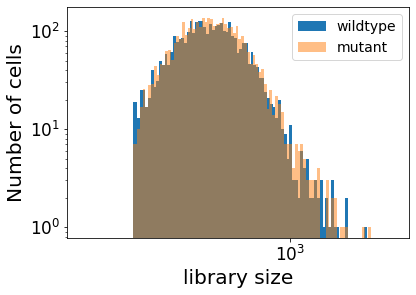

In [16]:
ax = scprep.plot.histogram(rna_adata.obs['library_size'][rna_adata.obs['sample'] == sample[0]], log=True, label = 'wildtype')
ax = scprep.plot.histogram(rna_adata.obs['library_size'][rna_adata.obs['sample'] == sample[1]], log=True, ax=ax, alpha=0.5, xlabel = 'library size', label = 'mutant', legend = True)

In [17]:
import graphtools

rna_data = graphtools.Graph(rna_adata.X, knn=15, n_pca=100, n_jobs=5)
atac_data = graphtools.Graph(atac_adata.X, knn=15, n_pca=100, n_jobs=5)

In [18]:
import phate
phate_op = phate.PHATE()
rna_adata.obsm['X_phate'] = phate_op.fit_transform(rna_data)


Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7750 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.29 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.57 seconds.
  Calculated landmark operator in 17.44 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 1.60 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.07 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.96 seconds.
Calculated PHATE in 25.16 seconds.


In [19]:
import phate
phate_op = phate.PHATE()
atac_adata.obsm['X_phate'] = phate_op.fit_transform(atac_data)


Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7750 observations.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.25 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.07 seconds.
  Calculated landmark operator in 16.81 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 1.62 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.94 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.05 seconds.
Calculated PHATE in 24.51 seconds.


In [20]:
import meld

# Estimate density of each sample over the graph
sample_densities = meld.MELD().fit_transform(rna_adata.X, rna_adata.obs['sample'])

# Normalize densities to calculate sample likelihoods
sample_likelihoods = meld.utils.normalize_densities(sample_densities)

Building graph on 7750 samples and 17310 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.63 seconds.
  Calculating KNN search...
  Calculated KNN search in 6.80 seconds.
  Calculating affinities...
  Calculated affinities in 2.08 seconds.
Calculated graph and diffusion operator in 10.97 seconds.


<AxesSubplot:title={'center':'RNA library size'}>

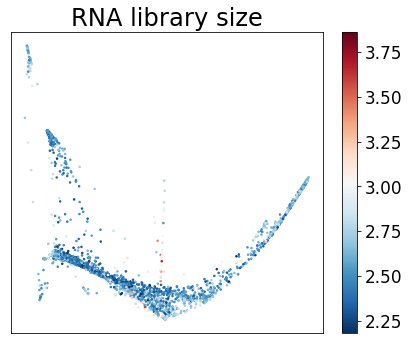

In [21]:
scprep.plot.scatter2d(rna_adata.obsm["X_phate"], c=np.log10(rna_adata.obs['library_size']), cmap='RdBu_r',
                      figsize=(6,5),
                     title='RNA library size', ticks=False)

<AxesSubplot:title={'center':'RNA mutant likelihood'}>

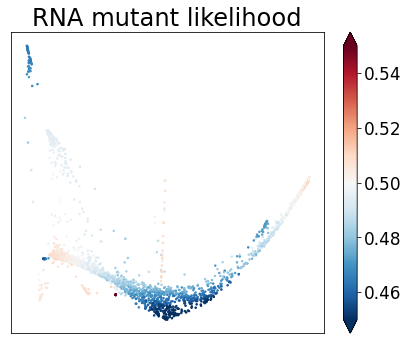

In [22]:
scprep.plot.scatter2d(rna_adata.obsm["X_phate"], c=sample_likelihoods["mutant"], cmap='RdBu_r',
                      figsize=(6,5),
                     title='RNA mutant likelihood', vmin = 0.45, vmax = 0.55, ticks=False)

<AxesSubplot:title={'center':'RNA mitochondrial %'}>

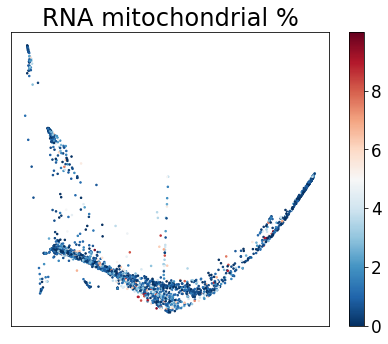

In [23]:
scprep.plot.scatter2d(rna_adata.obsm["X_phate"], c=rna_adata.obs.pct_counts_mt, cmap='RdBu_r',
                      figsize=(6,5),
                     title='RNA mitochondrial %', ticks=False)

In [26]:
!pip install multiscale-phate

In [32]:
import multiscale_phate as mp
import numpy as np
import pandas as pd

import scprep
import os

In [33]:
mp_op = mp.Multiscale_PHATE()

rna_levels = mp_op.fit(pd.DataFrame(rna_adata.X.toarray()))

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 4.44 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 25.72 seconds.
  Setting epsilon to 0.9799
  Setting merge threshold to 0.082
  Calculating condensation...
  Calculated condensation in 12.03 seconds.
Calculated Multiscale PHATE tree in 42.92 seconds.
Computing gradient...
Identifying salient levels of resolution...


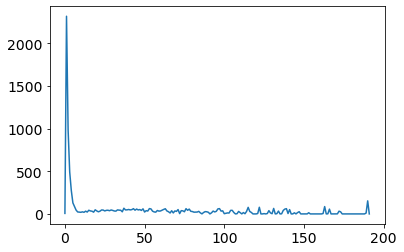

In [34]:
import matplotlib.pyplot as plt
plt.plot(mp_op.gradient)

In [35]:
rna_levels

[0, 10, 12, 66, 72, 86, 91, 107, 119, 135, 142, 151, 161, 170, 188]

In [36]:
mp_op.NxTs

[array([   0,    1,    2, ..., 7747, 7748, 7749]),
 array([   0,    1,    2, ..., 7747, 7748, 7749]),
 array([   0,    1,    2, ..., 7747, 7748, 7749]),
 array([   0,    1,    2, ...,  605, 7748, 7749]),
 array([   0,    1,    2, ...,  605, 7748, 7749]),
 array([   0,    1,    2, ...,   93, 7748, 7749]),
 array([   0,    1,    2, ...,   93, 7748, 7749]),
 array([   0,    1,    2, ...,   93, 7748, 7749]),
 array([   0,    1,    2, ...,   93, 7748, 7749]),
 array([   0,    1,    2, ...,    2, 7748, 7749]),
 array([   0,    1,    2, ...,    2, 7748, 7749]),
 array([   0,    1,    2, ...,    2, 7748, 7749]),
 array([   0,    1,    2, ...,    2, 7748, 7749]),
 array([   0,    1,    2, ...,    2, 5744, 7749]),
 array([   0,    1,    2, ...,    2, 5744, 7749]),
 array([   0,    1,    2, ...,    2, 5744, 7749]),
 array([   0,    1,    2, ...,    2, 5744, 7749]),
 array([   0,    1,    2, ...,    2, 5744, 7749]),
 array([   0,    1,    2, ...,    2, 5744, 7749]),
 array([   0,    1,    2, ..., 

In [37]:
mp_op.NxTs[rna_levels[10]]

array([0, 1, 1, ..., 1, 0, 0])

<AxesSubplot:title={'center':'RNA multiscale phate'}>

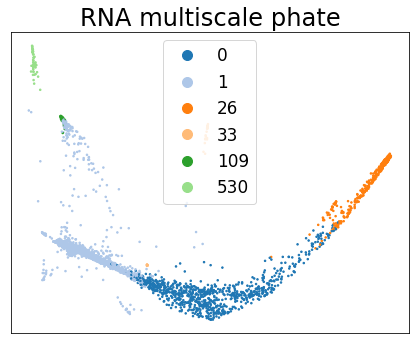

In [40]:
scprep.plot.scatter2d(rna_adata.obsm["X_phate"], c=mp_op.NxTs[rna_levels[12]], cmap='tab20',
                      figsize=(6,5),
                     title='RNA multiscale phate', ticks=False)

In [41]:
import meld

# Estimate density of each sample over the graph
sample_densities = meld.MELD().fit_transform(atac_adata.X, atac_adata.obs['sample'])

# Normalize densities to calculate sample likelihoods
sample_likelihoods = meld.utils.normalize_densities(sample_densities)

Building graph on 7750 samples and 191151 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 37.42 seconds.
  Calculating KNN search...
  Calculated KNN search in 7.18 seconds.
  Calculating affinities...
  Calculated affinities in 2.20 seconds.
Calculated graph and diffusion operator in 47.02 seconds.


<AxesSubplot:title={'center':'ATAC library size'}>

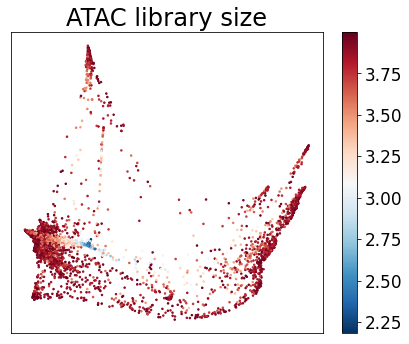

In [42]:
scprep.plot.scatter2d(atac_adata.obsm["X_phate"], c=np.log10(atac_adata.obs['library_size']), cmap='RdBu_r',
                      figsize=(6,5),
                     title='ATAC library size', ticks=False)

<AxesSubplot:title={'center':'ATAC mutant likelihood'}>

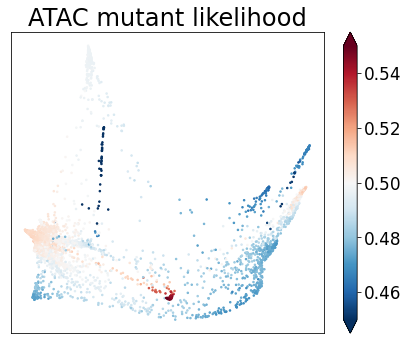

In [43]:
scprep.plot.scatter2d(atac_adata.obsm["X_phate"], c=sample_likelihoods["mutant"], cmap='RdBu_r',
                      figsize=(6,5),
                     title='ATAC mutant likelihood', vmin = 0.45, vmax = 0.55, ticks=False)

In [44]:
mp_op = mp.Multiscale_PHATE()

atac_levels = mp_op.fit(pd.DataFrame(atac_adata.X.toarray()))

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 50.18 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 26.19 seconds.
  Setting epsilon to 0.9511
  Setting merge threshold to 0.0786
  Calculating condensation...
  Calculated condensation in 14.16 seconds.
Calculated Multiscale PHATE tree in 91.08 seconds.
Computing gradient...
Identifying salient levels of resolution...


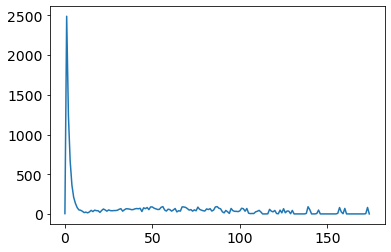

In [45]:
import matplotlib.pyplot as plt
plt.plot(mp_op.gradient)

In [46]:
atac_levels

[0, 11, 13, 91, 94, 106, 115, 136, 142, 154, 171]

In [47]:
mp_op.NxTs

[array([   0,    1,    2, ..., 7747, 7748, 7749]),
 array([   0,    1,    2, ..., 7747, 7748, 7749]),
 array([   0,    1,    2, ..., 7747, 1488, 7749]),
 array([   0,    1,    2, ..., 7747, 1488, 2479]),
 array([   0,    1,    2, ..., 7747, 1488, 2479]),
 array([   0,    1,    2, ..., 7747, 1488,  246]),
 array([   0,    1,    2, ..., 7747, 1488,  246]),
 array([   0,    1,    2, ...,  644, 1488,  241]),
 array([   0,    1,    2, ...,   60, 1488,  241]),
 array([   0,    1,    2, ...,   60, 1488,  241]),
 array([   0,    1,    2, ...,   60, 1488,  241]),
 array([   0,    1,    2, ...,   60, 1488,  241]),
 array([   0,    1,    2, ...,   60, 1488,   10]),
 array([   0,    1,    2, ...,   60, 1488,   10]),
 array([   0,    1,    2, ...,   60, 1488,   10]),
 array([   0,    1,    2, ...,   60, 1488,   10]),
 array([   0,    1,    2, ...,   60, 1488,   10]),
 array([   0,    1,    2, ...,   60, 1488,   10]),
 array([   0,    1,    2, ...,   60, 1488,    8]),
 array([   0,    1,    2, ..., 

In [48]:
mp_op.NxTs[atac_levels[6]]

array([ 0,  1,  1, ...,  1, 43,  1])

<AxesSubplot:title={'center':'ATAC multiscale phate'}>

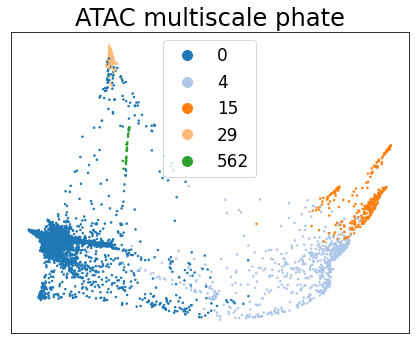

In [53]:
scprep.plot.scatter2d(atac_adata.obsm["X_phate"], c=mp_op.NxTs[atac_levels[9]], cmap='tab20',
                      figsize=(6,5),
                     title='ATAC multiscale phate', ticks=False)

# Integrated Diffusion

In [94]:
import numpy as np
import pandas as pd
import phate
import graphtools
import matplotlib.pyplot as plt
import scprep
import integrated_diffusion_v1 as i_diff

In [95]:
import integrated_diffusion_v1 as i_diff

In [96]:
import warnings
warnings.simplefilter('ignore')

In [97]:
sc.pp.pca(rna_adata2)
sc.pp.pca(atac_adata2)

In [98]:
G_rna = graphtools.Graph(rna_adata2.obsm['X_pca'], knn=15, n_jobs=5, n_landmark=2000)

In [99]:
G_atac = graphtools.Graph(atac_adata2.obsm['X_pca'], knn=15, n_jobs=5, n_landmark=2000)

In [100]:
phate_op_atac = phate.PHATE(random_state = 12)
atac_phate = phate_op_atac.fit_transform(G_atac)

Calculating PHATE...
  Running PHATE on 14682 observations and 50 variables.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.41 seconds.
    Calculating KMeans...
    Calculated KMeans in 16.47 seconds.
  Calculated landmark operator in 19.48 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 1.84 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.07 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.53 seconds.
Calculated PHATE in 27.93 seconds.


In [101]:
phate_op_rna = phate.PHATE(random_state = 12)
rna_phate = phate_op_rna.fit_transform(G_rna)

Calculating PHATE...
  Running PHATE on 14682 observations and 50 variables.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.65 seconds.
    Calculating KMeans...
    Calculated KMeans in 21.91 seconds.
  Calculated landmark operator in 26.52 seconds.
  Calculating optimal t...
    Automatically selected t = 4
  Calculated optimal t in 1.82 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.42 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.96 seconds.
Calculated PHATE in 34.72 seconds.


In [102]:
# Step 1
### correcting each graph

In [103]:
num_clusters = 20
num_vectors = [100, 50, 25]

In [104]:
aff_op_rna, clusters_landmark_rna = i_diff.graph_correction(G_rna.K.toarray(),
                                                            num_clusters=num_clusters,
                                                            num_vectors = num_vectors)

rna_phate_corr, t_rna_corr, landmark_op_rna, pnm_rna, pmn_rna = i_diff.embed_phate(aff_op_rna,
                                                                                   clusters_landmark_rna)

Iteration:0
Iteration:1
Iteration:2


In [105]:
aff_op_atac, clusters_landmark_atac = i_diff.graph_correction(G_atac.K.toarray(),
                                                              num_clusters=num_clusters,
                                                              num_vectors = num_vectors)

atac_phate_corr, t_atac_corr, landmark_op_atac, pnm_atac, pmn_atac = i_diff.embed_phate(aff_op_atac,
                                                                                        clusters_landmark_atac)

Iteration:0
Iteration:1
Iteration:2


In [106]:
# step 2 integrating operators
# returns integrated diffusion operator & phate embedding

In [107]:
i_diff_op, i_phate = i_diff.integrate_operators(landmark_op_rna, pnm_rna, pmn_rna,
                                                landmark_op_atac, pnm_atac, pmn_atac)

Computing clusters...
Computing landmarks...


In [109]:
mpl.rc_file_defaults()

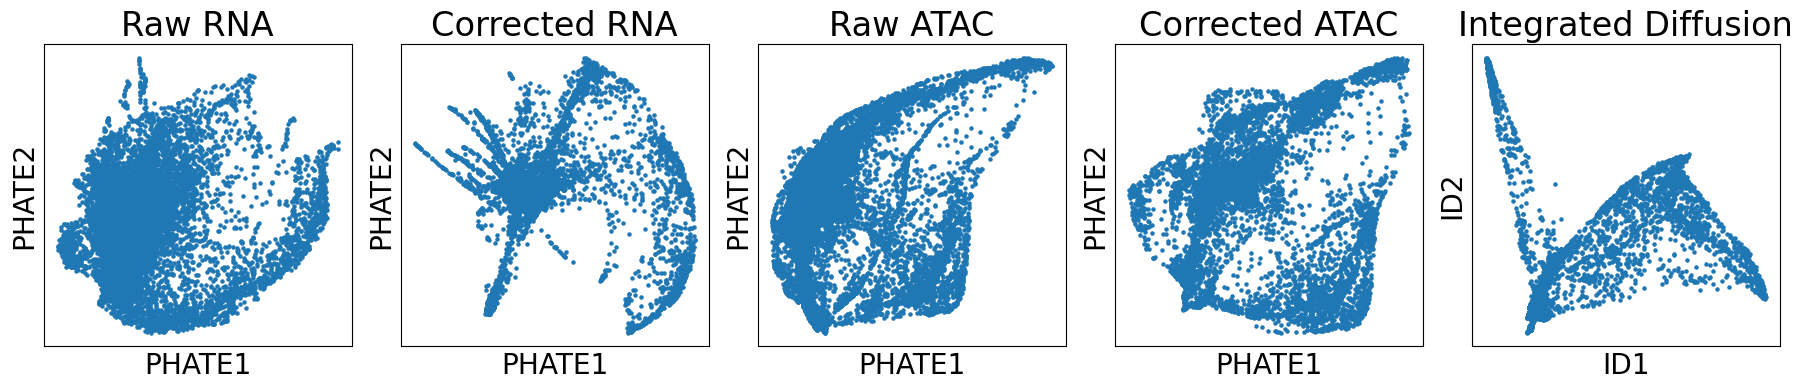

In [110]:
fig, axes = plt.subplots(1,5, figsize=(18, 4))

scprep.plot.scatter2d(rna_phate, ax=axes[0], title="Raw RNA",
                      xticks=False, yticks=False, label_prefix='PHATE', fontsize=14, s=5)

scprep.plot.scatter2d(rna_phate_corr, ax=axes[1], title="Corrected RNA",
                      xticks=False, yticks=False, label_prefix='PHATE', fontsize=14, s=5)

scprep.plot.scatter2d(atac_phate, ax=axes[2], title="Raw ATAC",
                      xticks=False, yticks=False, label_prefix='PHATE', fontsize=14, s=5)

scprep.plot.scatter2d(atac_phate_corr, ax=axes[3], title="Corrected ATAC",
                      xticks=False, yticks=False, label_prefix='PHATE', fontsize=14, s=5)

scprep.plot.scatter2d(i_phate, ax=axes[4], title="Integrated Diffusion",
                      xticks=False, yticks=False, label_prefix='ID', fontsize=14, s=5)

fig.tight_layout()

In [111]:
binarized_sample = np.where(rna_adata2.obs[0] == 'WT', 0, 1) # wildtype = 0, mutant = 1
binarized_sample = binarized_sample - np.mean(binarized_sample) + .5
integrated_meld = i_diff_op @ binarized_sample

<AxesSubplot:title={'center':'integrated mutant likelihood'}, xlabel='integrated PHATE1', ylabel='integrated PHATE2'>

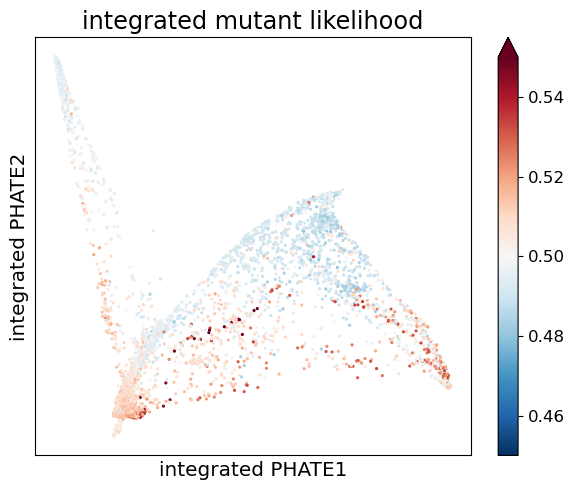

In [116]:
scprep.plot.scatter2d(i_phate, c=integrated_meld, cmap='RdBu_r',
                      figsize=(6,5), label_prefix='integrated PHATE',
                     title='integrated mutant likelihood', vmin = 0.45, vmax = 0.55, ticks=False,
                     filename='../zebrafish/img/2d_integrated_mutant_likelihood.png', dpi=150)


In [137]:
integrated_meld_2 = i_diff_op @ integrated_meld

<AxesSubplot:title={'center':'integrated mutant likelihood'}>

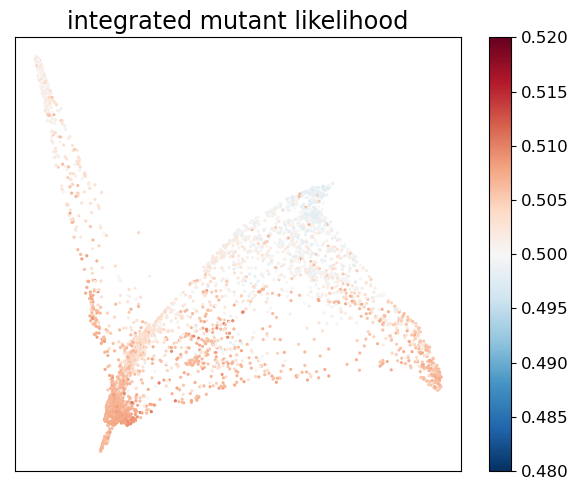

In [138]:
mpl.rc_file_defaults()
scprep.plot.scatter2d(i_phate, c=integrated_meld_2, cmap='RdBu_r',
                      figsize=(6,5),
                     title='integrated mutant likelihood', vmin = 0.48, vmax = 0.52, ticks=False)

In [139]:
rna_adata2.obs

0                   1   2  n_genes_by_counts  \
AAACAGCCAAATATCC-1   WT  AAACAGCCAAATATCC-1   1                605   
AAACATGCAACTAGGG-1   WT  AAACATGCAACTAGGG-1   9                284   
AAACATGCAAGACTCC-1   WT  AAACATGCAAGACTCC-1  36                352   
AAACATGCATCGCTTT-1   WT  AAACATGCATCGCTTT-1   2                223   
AAACCAACAACTAACT-1   WT  AAACCAACAACTAACT-1   0                278   
...                 ...                 ...  ..                ...   
TTTGTGTTCCTTGAGG-2  MUT  TTTGTGTTCCTTGAGG-2   5                326   
TTTGTGTTCGCTTGCT-2  MUT  TTTGTGTTCGCTTGCT-2  29                177   
TTTGTTGGTATTGGTG-2  MUT  TTTGTTGGTATTGGTG-2   2                427   
TTTGTTGGTTAAGTGT-2  MUT  TTTGTTGGTTAAGTGT-2  21                201   
TTTGTTGGTTGGTTGA-2  MUT  TTTGTTGGTTGGTTGA-2   3                709   

                    total_counts  total_counts_mt  pct_counts_mt  
AAACAGCCAAATATCC-1         748.0              0.0            0.0  
AAACATGCAACTAGGG-1         337.0              0.0            0.0  
AAACATGCAAGACTCC-1         408.0              0.0            0.0  
AAACATGCATCGCTTT-1         243.0              0.0            0.0  
AAACCAACAACTAACT-1         334.0              0.0            0.0  
...                          ...              ...            ...  
TTTGTGTTCCTTGAGG-2         377.0              0.0            0.0  
TTTGTGTTCGCTTGCT-2         201.0              0.0            0.0  
TTTGTTGGTATTGGTG-2         540.0              0.0            0.0  
TTTGTTGGTTAAGTGT-2         227.0              0.0            0.0  
TTTGTTGGTTGGTTGA-2        1091.0              0.0            0.0  

[14682 rows x 7 columns]

In [140]:
d = {'barcode': rna_adata2.obs_names, 'sample': rna_adata2.obs[0].tolist(), 'meld': integrated_meld, 'clusters': rna_adata2.obs[2], 'cond_clusters': rna_adata2.obs[2]}
df = pd.DataFrame(data=d)
df

barcode sample      meld  clusters  \
AAACAGCCAAATATCC-1  AAACAGCCAAATATCC-1     WT  0.509439         1   
AAACATGCAACTAGGG-1  AAACATGCAACTAGGG-1     WT  0.507895         9   
AAACATGCAAGACTCC-1  AAACATGCAAGACTCC-1     WT  0.507959        36   
AAACATGCATCGCTTT-1  AAACATGCATCGCTTT-1     WT  0.495553         2   
AAACCAACAACTAACT-1  AAACCAACAACTAACT-1     WT  0.506780         0   
...                                ...    ...       ...       ...   
TTTGTGTTCCTTGAGG-2  TTTGTGTTCCTTGAGG-2    MUT  0.507180         5   
TTTGTGTTCGCTTGCT-2  TTTGTGTTCGCTTGCT-2    MUT  0.495093        29   
TTTGTTGGTATTGGTG-2  TTTGTTGGTATTGGTG-2    MUT  0.500025         2   
TTTGTTGGTTAAGTGT-2  TTTGTTGGTTAAGTGT-2    MUT  0.489964        21   
TTTGTTGGTTGGTTGA-2  TTTGTTGGTTGGTTGA-2    MUT  0.503627         3   

                    cond_clusters  
AAACAGCCAAATATCC-1              1  
AAACATGCAACTAGGG-1              9  
AAACATGCAAGACTCC-1             36  
AAACATGCATCGCTTT-1              2  
AAACCAACAACTAACT-1              0  
...                           ...  
TTTGTGTTCCTTGAGG-2              5  
TTTGTGTTCGCTTGCT-2             29  
TTTGTTGGTATTGGTG-2              2  
TTTGTTGGTTAAGTGT-2             21  
TTTGTTGGTTGGTTGA-2              3  

[14682 rows x 5 columns]

In [141]:
df = df.drop(df[df['clusters'].isin([2, 4, 5, 6, 9, 40])].index)

In [142]:
df = df.replace({'cond_clusters': {28: 3, 33: 17, 34: 17, 41: 17, 29: 17, 23: 21, 24: 13, 25: 13, 31: 27, 39: 27, 26: 10, 22: 16}})
df = df.replace({'cond_clusters': {0: 'neurons_glutamatergic', 1: 'mid-hind boundary_GABAergic', 2: 'radial glia', 3: 'radial glia', 7: 'progenitors/neurons_differentiating', 8: 'granule cells', 10: 'optic tectum_GABAergic', 11: 'neurons_broad', 12: 'GABAergic neurons', 13: 'neurons_midbrain, glutamatergic', 14: 'telencephalon_glutamatergic', 15: 'hindbrain', 16: 'dorsal diencephalon_thalamus', 17: 'hypothalamus', 18: 'dead/dying', 19: 'neurons_telencephalon', 20: 'cranial ganglion_vagal', 21: 'ventral forebrain_dienc, hyp, poa: GABAergic', 27: 'dorsal habenula', 30: 'glial progenitors', 32: 'dorsal telencephalon_glutamatergic', 35: 'oligodendryocyte progenitor cells', 36: 'habenula/hindbrain, motor neurons', 37: 'microglia', 38: 'Purkinje neurons_GABAergic++', 42: 'ventral habenula'}})


In [ ]:
0neurons (glutamatergic)
1mid-hind boundary (GABAergic)
3radial glia 1
7progenitors/neurons (differentiating)
8granule cells
10optic tectum (GABAergic)
11neurons (broad)
12GABAergic neurons
13neurons (midbrain, glutamatergic)
14telencephalon (glutamatergic)
15hindbrain
16dorsal diencephalon (thalamus)
17hypothalamus
18dead/dying
19neurons (telencephalon)
20cranial ganglion (vagal)
21ventral forebrain (dienc, hyp, poa: GABAergic)
27dorsal habenula
30glial progenitors
32dorsal telencephalon (glutamatergic)
35oligodendryocyte progenitor cells
36habenula/hindbrain, motor neurons?
37microglia
38Purkinje neurons (GABAergic++)
42ventral habenula

In [152]:
df.to_csv('MELD_for_seurat_clusters.csv')

<AxesSubplot:title={'center':'MELD for seurat_clusters'}, xlabel='clusters', ylabel='meld'>

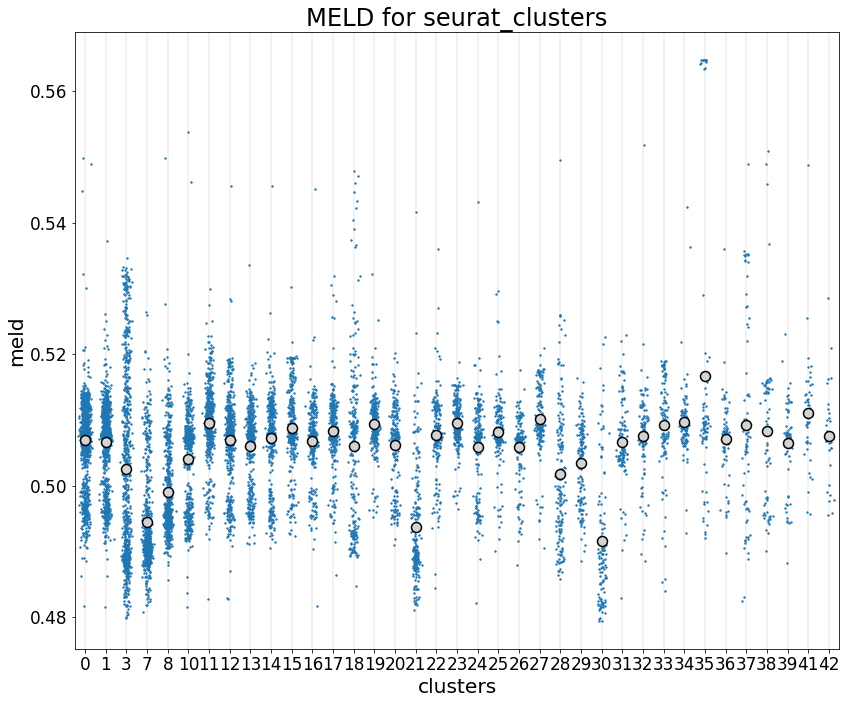

In [63]:
scprep.plot.jitter(df["clusters"], df["meld"], title='MELD for seurat_clusters', figsize=(12,10))

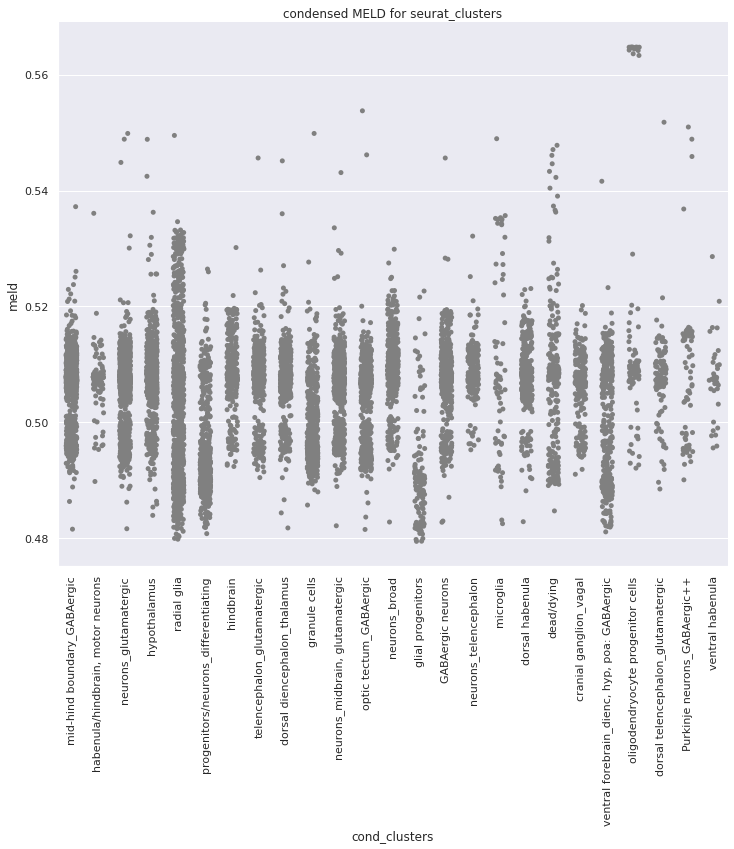

In [128]:
import seaborn as sns

sns.set(rc={'figure.figsize':(12,10)}) 
ax = sns.stripplot("cond_clusters", "meld", data=df, jitter=0.2, color='grey').set(title='condensed MELD for seurat_clusters') 
plt.xticks(rotation=90) 
sns.despine()


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'GABAergic neurons'),
  Text(1, 0, 'Purkinje neurons_GABAergic++'),
  Text(2, 0, 'cranial ganglion_vagal'),
  Text(3, 0, 'dead/dying'),
  Text(4, 0, 'dorsal diencephalon_thalamus'),
  Text(5, 0, 'dorsal habenula'),
  Text(6, 0, 'dorsal telencephalon_glutamatergic'),
  Text(7, 0, 'glial progenitors'),
  Text(8, 0, 'granule cells'),
  Text(9, 0, 'habenula/hindbrain, motor neurons'),
  Text(10, 0, 'hindbrain'),
  Text(11, 0, 'hypothalamus'),
  Text(12, 0, 'microglia'),
  Text(13, 0, 'mid-hind boundary_GABAergic'),
  Text(14, 0, 'neurons_broad'),
  Text(15, 0, 'neurons_glutamatergic'),
  Text(16, 0, 'neurons_midbrain, glutamatergic'),
  Text(17, 0, 'neurons_telencephalon'),
  Text(18, 0, 'oligodendryocyte progenitor cells'),
  Text(19, 0, 'optic tectum_GABAergic'),
  Text(20, 0, 'progenitors/neurons_differentiating'),
  Text(21, 0, 'radial glia'),
  Text(22, 0,

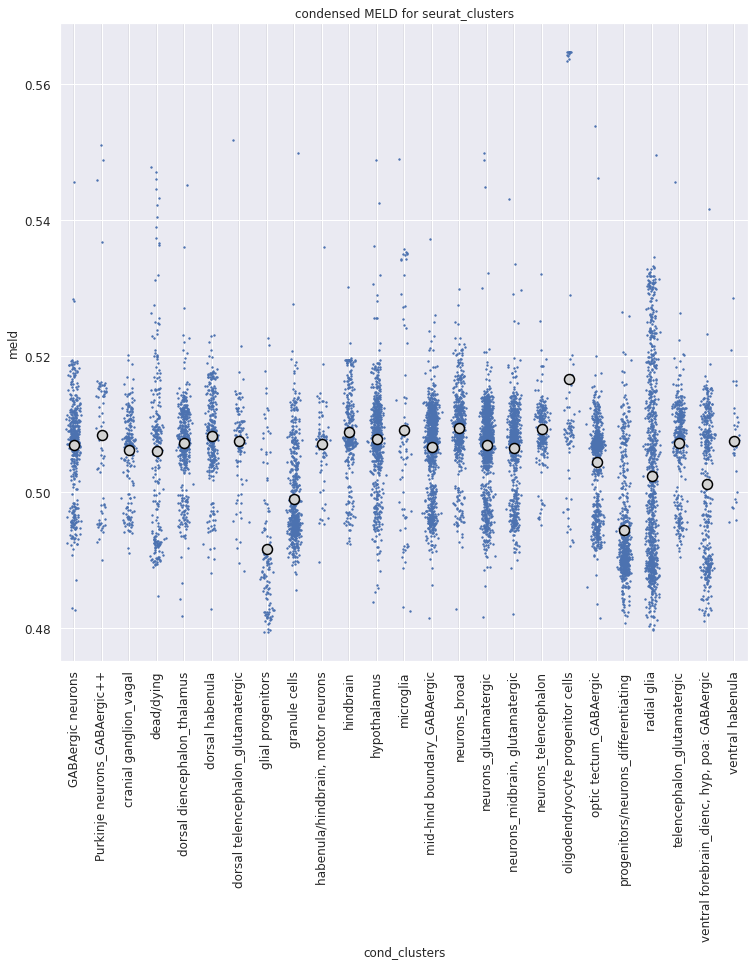

In [130]:
ax = scprep.plot.jitter(df["cond_clusters"], df["meld"], title='condensed MELD for seurat_clusters', figsize=(12,10))
plt.xticks(rotation=90) 


In [64]:
min(integrated_meld)

0.47944784733488127

In [65]:
max(integrated_meld)

0.5647446548919529

In [171]:
d2 = {'barcode': rna_adata2.obs_names, 'sample': rna_adata2.obs[0].tolist(), 'meld': integrated_meld_2, 'clusters': rna_adata2.obs[2], 'cond_clusters': rna_adata2.obs[2]}
df2 = pd.DataFrame(data=d2)
df2

barcode sample      meld  clusters  \
AAACAGCCAAATATCC-1  AAACAGCCAAATATCC-1     WT  0.506960         1   
AAACATGCAACTAGGG-1  AAACATGCAACTAGGG-1     WT  0.506282         9   
AAACATGCAAGACTCC-1  AAACATGCAAGACTCC-1     WT  0.506547        36   
AAACATGCATCGCTTT-1  AAACATGCATCGCTTT-1     WT  0.503430         2   
AAACCAACAACTAACT-1  AAACCAACAACTAACT-1     WT  0.506415         0   
...                                ...    ...       ...       ...   
TTTGTGTTCCTTGAGG-2  TTTGTGTTCCTTGAGG-2    MUT  0.506457         5   
TTTGTGTTCGCTTGCT-2  TTTGTGTTCGCTTGCT-2    MUT  0.503368        29   
TTTGTTGGTATTGGTG-2  TTTGTTGGTATTGGTG-2    MUT  0.501006         2   
TTTGTTGGTTAAGTGT-2  TTTGTTGGTTAAGTGT-2    MUT  0.501265        21   
TTTGTTGGTTGGTTGA-2  TTTGTTGGTTGGTTGA-2    MUT  0.500235         3   

                    cond_clusters  
AAACAGCCAAATATCC-1              1  
AAACATGCAACTAGGG-1              9  
AAACATGCAAGACTCC-1             36  
AAACATGCATCGCTTT-1              2  
AAACCAACAACTAACT-1              0  
...                           ...  
TTTGTGTTCCTTGAGG-2              5  
TTTGTGTTCGCTTGCT-2             29  
TTTGTTGGTATTGGTG-2              2  
TTTGTTGGTTAAGTGT-2             21  
TTTGTTGGTTGGTTGA-2              3  

[14682 rows x 5 columns]

In [172]:
df2 = df2.drop(df2[df2['clusters'].isin([2, 4, 5, 6, 9, 40])].index)

In [173]:
df2 = df2.replace({'cond_clusters': {28: 3, 33: 17, 34: 17, 41: 17, 29: 17, 23: 21, 24: 13, 25: 13, 31: 27, 39: 27, 26: 10, 22: 16}})
df2 = df2.replace({'cond_clusters': {0: 'neurons_glutamatergic', 1: 'mid-hind boundary_GABAergic', 2: 'radial glia', 3: 'radial glia', 7: 'progenitors/neurons_differentiating', 8: 'granule cells', 10: 'optic tectum_GABAergic', 11: 'neurons_broad', 12: 'GABAergic neurons', 13: 'neurons_midbrain, glutamatergic', 14: 'telencephalon_glutamatergic', 15: 'hindbrain', 16: 'dorsal diencephalon_thalamus', 17: 'hypothalamus', 18: 'dead/dying', 19: 'neurons_telencephalon', 20: 'cranial ganglion_vagal', 21: 'ventral forebrain_dienc, hyp, poa: GABAergic', 27: 'dorsal habenula', 30: 'glial progenitors', 32: 'dorsal telencephalon_glutamatergic', 35: 'oligodendryocyte progenitor cells', 36: 'habenula/hindbrain, motor neurons', 37: 'microglia', 38: 'Purkinje neurons_GABAergic++', 42: 'ventral habenula'}})

<AxesSubplot:title={'center':'MELD for seurat_clusters'}, xlabel='clusters', ylabel='meld'>

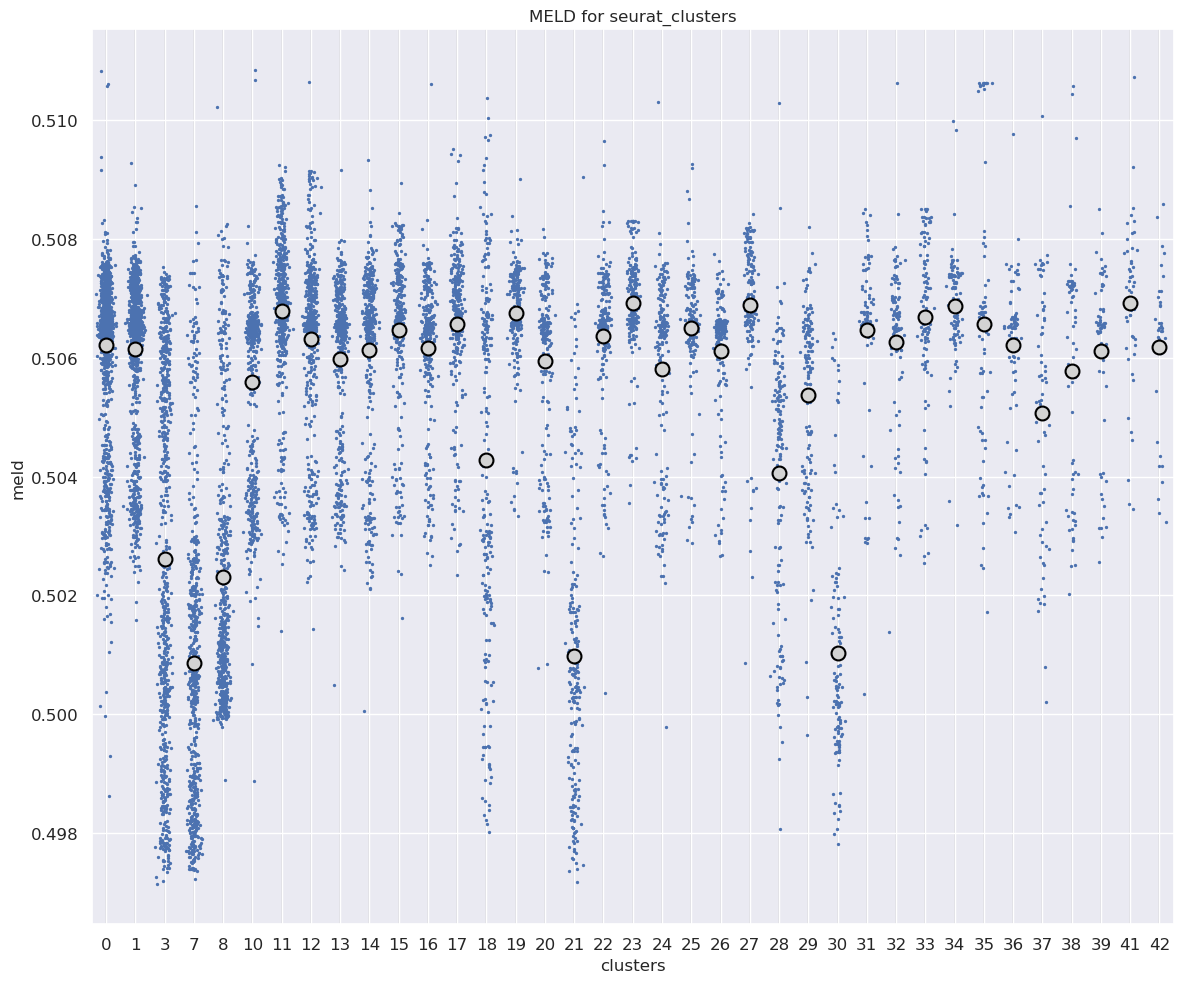

In [180]:
scprep.plot.jitter(df2["clusters"], df2["meld"], title='MELD for seurat_clusters', figsize=(12,10))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'GABAergic neurons'),
  Text(1, 0, 'Purkinje neurons_GABAergic++'),
  Text(2, 0, 'cranial ganglion_vagal'),
  Text(3, 0, 'dead/dying'),
  Text(4, 0, 'dorsal diencephalon_thalamus'),
  Text(5, 0, 'dorsal habenula'),
  Text(6, 0, 'dorsal telencephalon_glutamatergic'),
  Text(7, 0, 'glial progenitors'),
  Text(8, 0, 'granule cells'),
  Text(9, 0, 'habenula/hindbrain, motor neurons'),
  Text(10, 0, 'hindbrain'),
  Text(11, 0, 'hypothalamus'),
  Text(12, 0, 'microglia'),
  Text(13, 0, 'mid-hind boundary_GABAergic'),
  Text(14, 0, 'neurons_broad'),
  Text(15, 0, 'neurons_glutamatergic'),
  Text(16, 0, 'neurons_midbrain, glutamatergic'),
  Text(17, 0, 'neurons_telencephalon'),
  Text(18, 0, 'oligodendryocyte progenitor cells'),
  Text(19, 0, 'optic tectum_GABAergic'),
  Text(20, 0, 'progenitors/neurons_differentiating'),
  Text(21, 0, 'radial glia'),
  Text(22, 0,

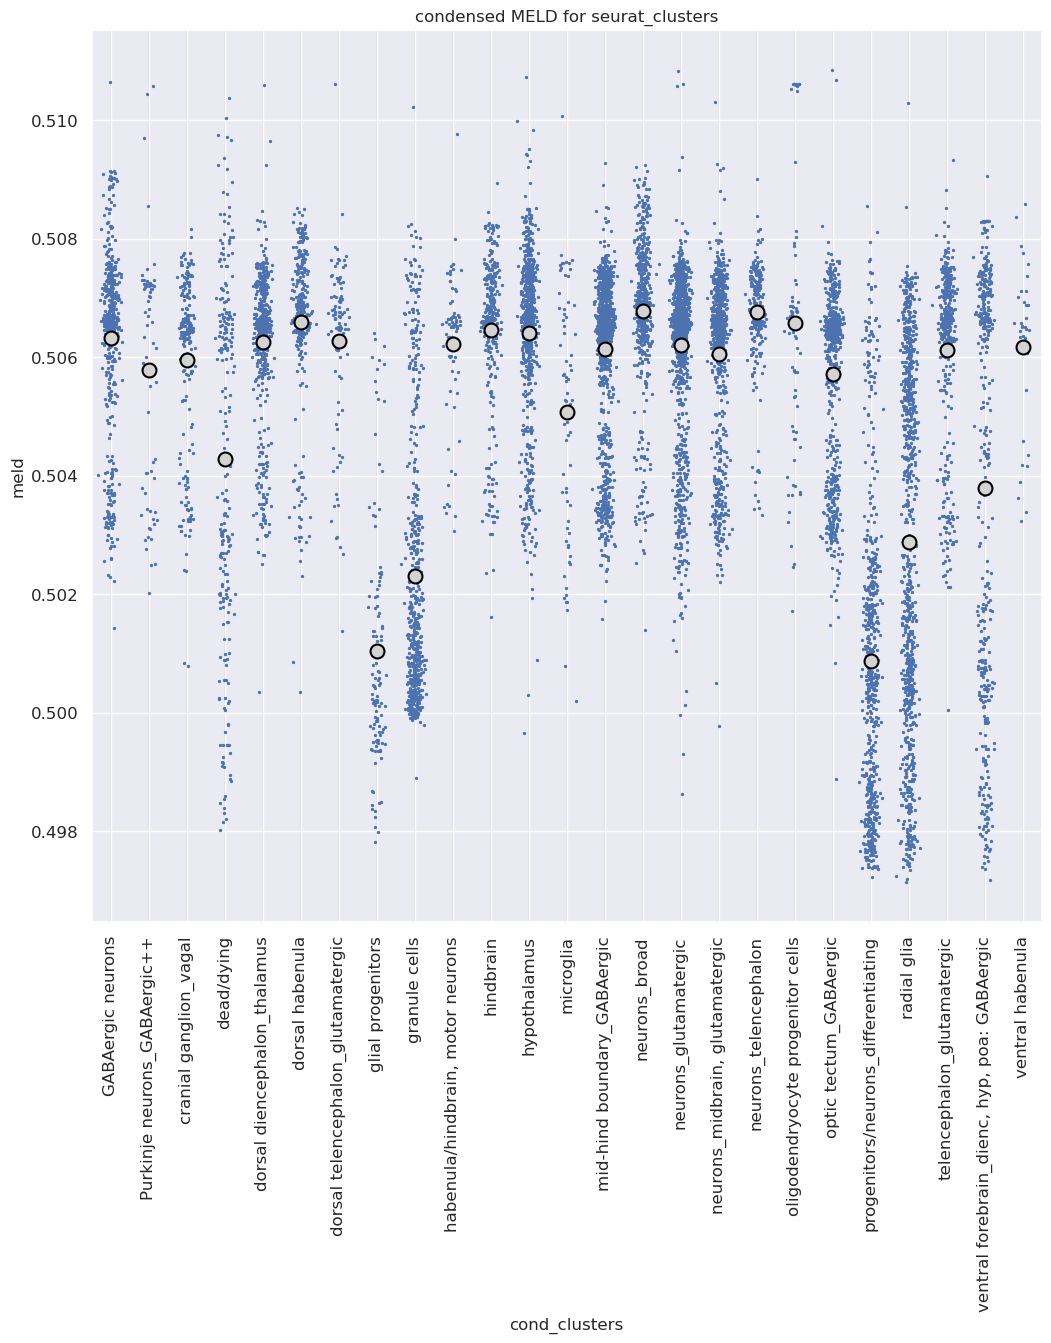

In [181]:
ax = scprep.plot.jitter(df2["cond_clusters"], df2["meld"], title='condensed MELD for seurat_clusters', figsize=(12,10))
plt.xticks(rotation=90) 


In [113]:
d = {'i_phate': i_phate.tolist(), 'cond_clusters': rna_adata2.obs[2]}
df = pd.DataFrame(data=d)
df


i_phate  \
AAACAGCCAAATATCC-1    [-0.009265654377237531, -0.00430809885290724]   
AAACATGCAACTAGGG-1   [-0.008916402167507947, -0.003771563783832365]   
AAACATGCAAGACTCC-1   [-0.009163011073645758, -0.004117207868939583]   
AAACATGCATCGCTTT-1  [-0.0069480921280305205, -0.002224002135243359]   
AAACCAACAACTAACT-1   [-0.00846391664708179, -0.0036131936718851593]   
...                                                             ...   
TTTGTGTTCCTTGAGG-2  [-0.008502187606231747, -0.0034896969214019604]   
TTTGTGTTCGCTTGCT-2  [-0.008089938358479447, -0.0033804764411705397]   
TTTGTTGGTATTGGTG-2   [-0.006874150200696846, -0.002354787403259326]   
TTTGTTGGTTAAGTGT-2     [0.00666165119847482, 0.0013846821038434477]   
TTTGTTGGTTGGTTGA-2    [0.001561939978539358, -0.001354971235595293]   

                    cond_clusters  
AAACAGCCAAATATCC-1              1  
AAACATGCAACTAGGG-1              9  
AAACATGCAAGACTCC-1             36  
AAACATGCATCGCTTT-1              2  
AAACCAACAACTAACT-1              0  
...                           ...  
TTTGTGTTCCTTGAGG-2              5  
TTTGTGTTCGCTTGCT-2             29  
TTTGTTGGTATTGGTG-2              2  
TTTGTTGGTTAAGTGT-2             21  
TTTGTTGGTTGGTTGA-2              3  

[14682 rows x 2 columns]

In [114]:
df = df.drop(df[df['cond_clusters'].isin([2, 4, 5, 6, 9, 40])].index)

In [115]:
df = df.replace({'cond_clusters': {28: 3, 33: 17, 34: 17, 41: 17, 29: 17, 23: 21, 24: 13, 25: 13, 31: 27, 39: 27, 26: 10, 22: 16}})
df = df.replace({'cond_clusters': {0: 'neurons_glutamatergic', 1: 'mid-hind boundary_GABAergic', 2: 'radial glia', 3: 'radial glia', 7: 'progenitors/neurons_differentiating', 8: 'granule cells', 10: 'optic tectum_GABAergic', 11: 'neurons_broad', 12: 'GABAergic neurons', 13: 'neurons_midbrain, glutamatergic', 14: 'telencephalon_glutamatergic', 15: 'hindbrain', 16: 'dorsal diencephalon_thalamus', 17: 'hypothalamus', 18: 'dead/dying', 19: 'neurons_telencephalon', 20: 'cranial ganglion_vagal', 21: 'ventral forebrain_dienc, hyp, poa: GABAergic', 27: 'dorsal habenula', 30: 'glial progenitors', 32: 'dorsal telencephalon_glutamatergic', 35: 'oligodendryocyte progenitor cells', 36: 'habenula/hindbrain, motor neurons', 37: 'microglia', 38: 'Purkinje neurons_GABAergic++', 42: 'ventral habenula'}})


<AxesSubplot:title={'center':'integrated PHATE of cond_clusters'}, xlabel='integrated PHATE1', ylabel='integrated PHATE2'>

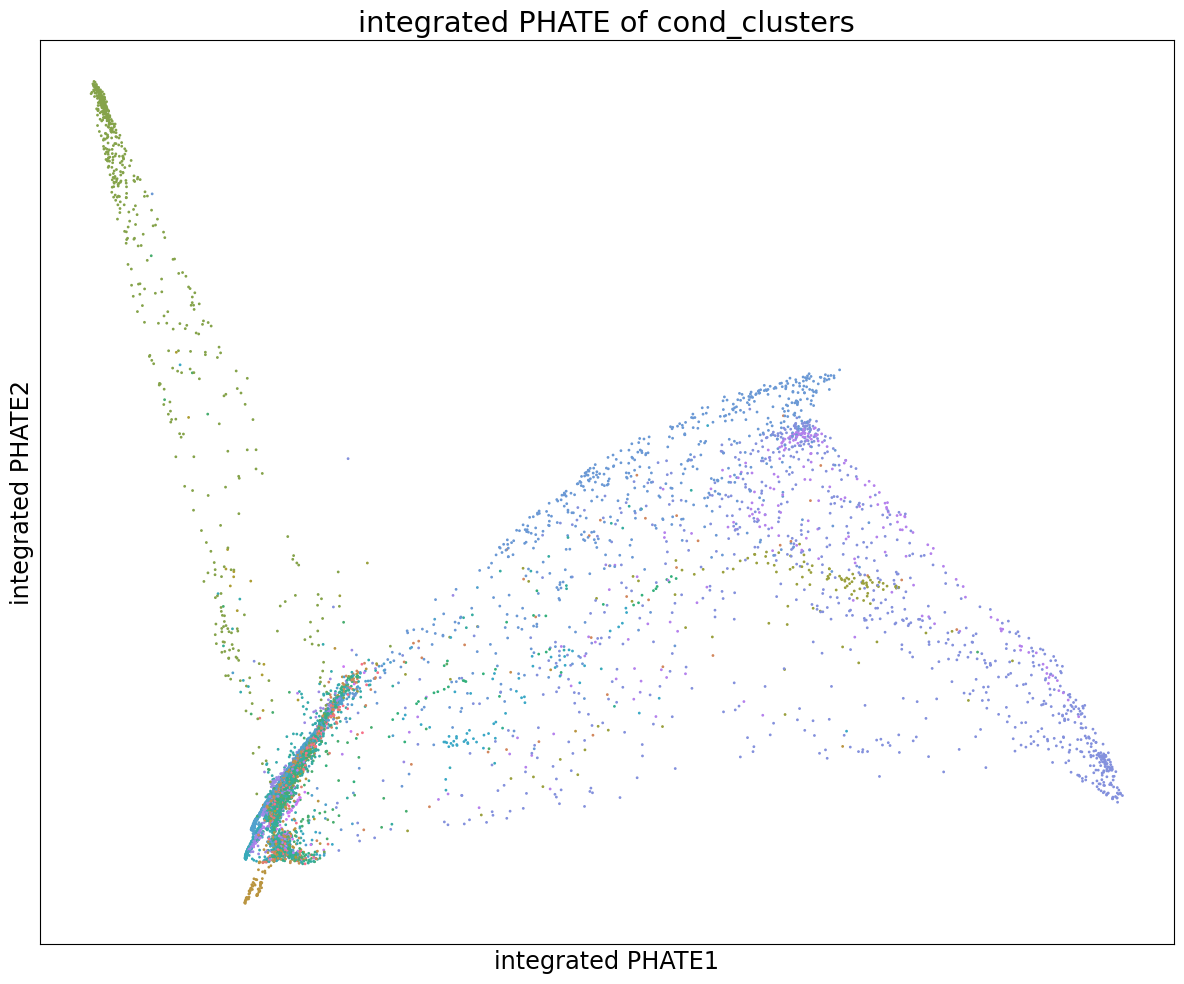

In [120]:
scprep.plot.scatter2d(df["i_phate"].tolist(), c=df["cond_clusters"].tolist(), cmap=sns.husl_palette(5), s=1, 
                      figsize=(12,10), ticks=None, label_prefix='integrated PHATE',
                     legend=False, fontsize=12, title='integrated PHATE of cond_clusters',
                     filename='../zebrafish/img/2d_integrated_PHATE_of_cond_clusters.png', dpi=150)


## 3D Integrated PHATE

In [32]:
phate_op_atac = phate.PHATE(n_components=3, random_state = 12)
atac_phate = phate_op_atac.fit_transform(G_atac)

Calculating PHATE...
  Running PHATE on 14682 observations and 50 variables.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.57 seconds.
    Calculating KMeans...
    Calculated KMeans in 12.66 seconds.
  Calculated landmark operator in 15.72 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 1.69 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.93 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 28.21 seconds.
Calculated PHATE in 46.56 seconds.


In [33]:
phate_op_rna = phate.PHATE(n_components=3, random_state = 12)
rna_phate = phate_op_rna.fit_transform(G_rna)

Calculating PHATE...
  Running PHATE on 14682 observations and 50 variables.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.53 seconds.
    Calculating KMeans...
    Calculated KMeans in 13.54 seconds.
  Calculated landmark operator in 17.84 seconds.
  Calculating optimal t...
    Automatically selected t = 4
  Calculated optimal t in 1.73 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.42 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 54.58 seconds.
Calculated PHATE in 74.58 seconds.


In [34]:
# Step 1
### correcting each graph

In [35]:
num_clusters = 20
num_vectors = [100, 50, 25]

In [36]:
aff_op_rna, clusters_landmark_rna = i_diff.graph_correction(G_rna.K.toarray(),
                                                            num_clusters=num_clusters,
                                                            num_vectors = num_vectors)

rna_phate_corr, t_rna_corr, landmark_op_rna, pnm_rna, pmn_rna = i_diff.embed_phate(aff_op_rna,
                                                                                   clusters_landmark_rna)

Iteration:0
Iteration:1
Iteration:2


In [37]:
aff_op_atac, clusters_landmark_atac = i_diff.graph_correction(G_atac.K.toarray(),
                                                              num_clusters=num_clusters,
                                                              num_vectors = num_vectors)

atac_phate_corr, t_atac_corr, landmark_op_atac, pnm_atac, pmn_atac = i_diff.embed_phate(aff_op_atac,
                                                                                        clusters_landmark_atac)

Iteration:0
Iteration:1
Iteration:2


In [38]:
# step 2 integrating operators
# returns integrated diffusion operator & phate embedding

In [39]:
i_diff_op, i_phate = i_diff.integrate_operators(landmark_op_rna, pnm_rna, pmn_rna,
                                                landmark_op_atac, pnm_atac, pmn_atac)

Computing clusters...
Computing landmarks...


<Axes3DSubplot:title={'center':'Raw RNA'}, xlabel='PHATE1', ylabel='PHATE2'>

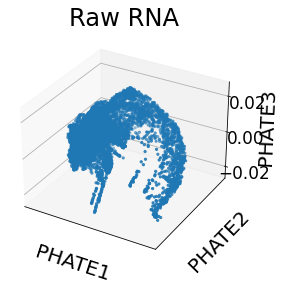

In [40]:
scprep.plot.scatter3d(rna_phate, title="Raw RNA",
                      xticks=False, yticks=False, label_prefix='PHATE', fontsize=14, s=5)

<Axes3DSubplot:title={'center':'Corrected RNA'}, xlabel='PHATE1', ylabel='PHATE2'>

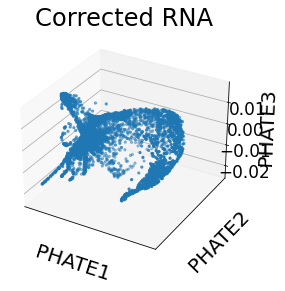

In [41]:
scprep.plot.scatter3d(rna_phate_corr, title="Corrected RNA",
                      xticks=False, yticks=False, label_prefix='PHATE', fontsize=14, s=5)

<Axes3DSubplot:title={'center':'Raw ATAC'}, xlabel='PHATE1', ylabel='PHATE2'>

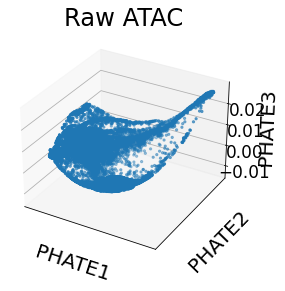

In [42]:
scprep.plot.scatter3d(atac_phate, title="Raw ATAC",
                      xticks=False, yticks=False, label_prefix='PHATE', fontsize=14, s=5)

<Axes3DSubplot:title={'center':'Corrected ATAC'}, xlabel='PHATE1', ylabel='PHATE2'>

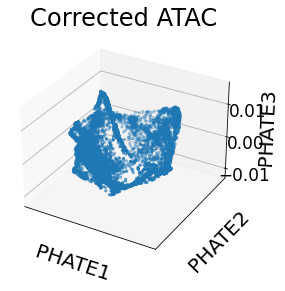

In [43]:
scprep.plot.scatter3d(atac_phate_corr, title="Corrected ATAC",
                      xticks=False, yticks=False, label_prefix='PHATE', fontsize=14, s=5)

<Axes3DSubplot:title={'center':'Integrated Diffusion'}, xlabel='ID1', ylabel='ID2'>

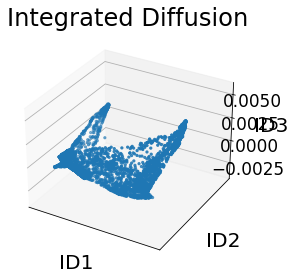

In [44]:
scprep.plot.scatter3d(i_phate, title="Integrated Diffusion",
                      xticks=False, yticks=False, label_prefix='ID', fontsize=14, s=5)

In [45]:
binarized_sample = np.where(rna_adata2.obs[0] == 'WT', 0, 1) # wildtype = 0, mutant = 1
binarized_sample = binarized_sample - np.mean(binarized_sample) + .5
integrated_meld = i_diff_op @ binarized_sample

<Axes3DSubplot:title={'center':'integrated mutant likelihood'}, xlabel='integrated PHATE1', ylabel='integrated PHATE2'>

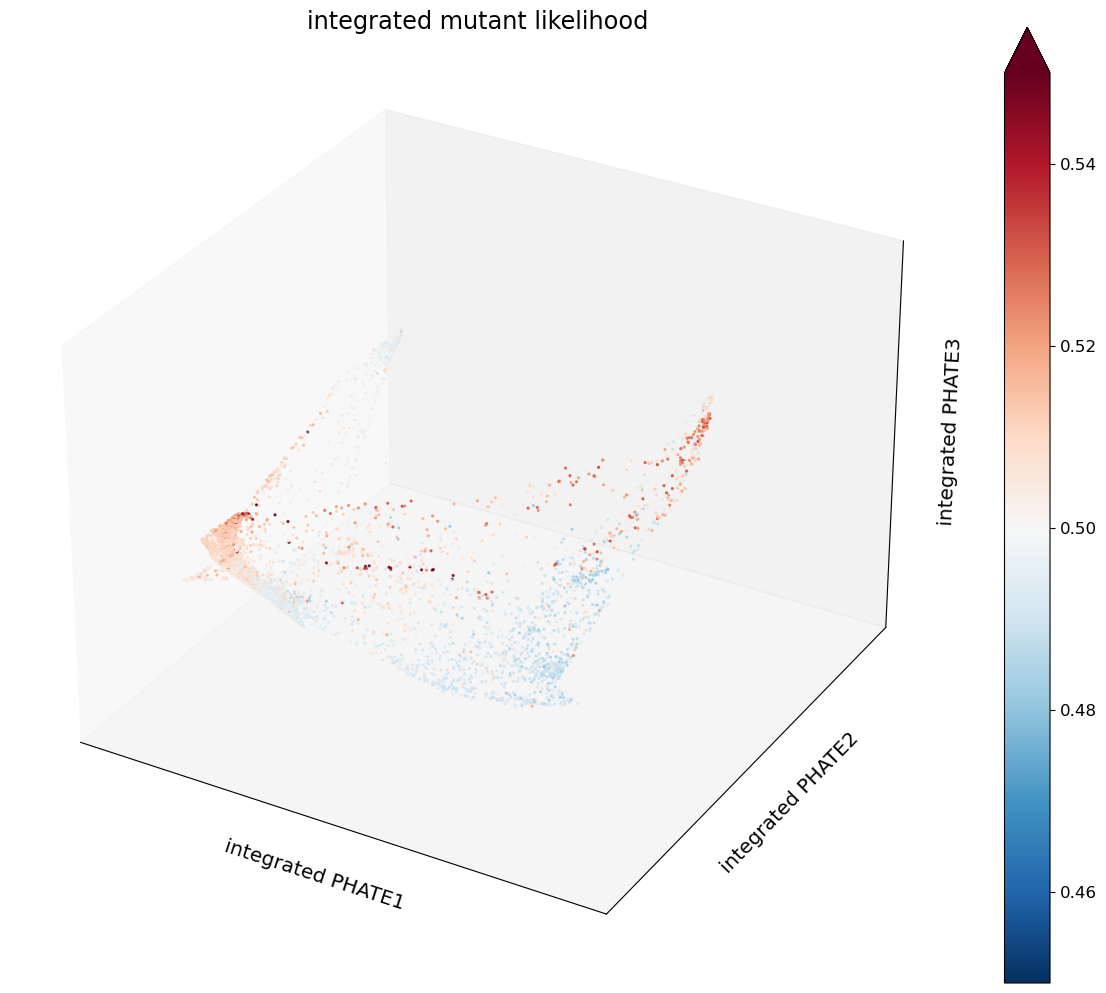

In [58]:
scprep.plot.scatter3d(i_phate, c=integrated_meld, cmap='RdBu_r',
                      figsize=(12,10), label_prefix='integrated PHATE',
                     title='integrated mutant likelihood', vmin = 0.45, vmax = 0.55, ticks=False, 
                      filename='../zebrafish/img/3d_integrated_mutant_likelihood.png', dpi=150)


In [83]:
rna_adata2.obs

0                   1   2  n_genes_by_counts  \
AAACAGCCAAATATCC-1   WT  AAACAGCCAAATATCC-1   1                605   
AAACATGCAACTAGGG-1   WT  AAACATGCAACTAGGG-1   9                284   
AAACATGCAAGACTCC-1   WT  AAACATGCAAGACTCC-1  36                352   
AAACATGCATCGCTTT-1   WT  AAACATGCATCGCTTT-1   2                223   
AAACCAACAACTAACT-1   WT  AAACCAACAACTAACT-1   0                278   
...                 ...                 ...  ..                ...   
TTTGTGTTCCTTGAGG-2  MUT  TTTGTGTTCCTTGAGG-2   5                326   
TTTGTGTTCGCTTGCT-2  MUT  TTTGTGTTCGCTTGCT-2  29                177   
TTTGTTGGTATTGGTG-2  MUT  TTTGTTGGTATTGGTG-2   2                427   
TTTGTTGGTTAAGTGT-2  MUT  TTTGTTGGTTAAGTGT-2  21                201   
TTTGTTGGTTGGTTGA-2  MUT  TTTGTTGGTTGGTTGA-2   3                709   

                    total_counts  total_counts_mt  pct_counts_mt  
AAACAGCCAAATATCC-1         748.0              0.0            0.0  
AAACATGCAACTAGGG-1         337.0              0.0            0.0  
AAACATGCAAGACTCC-1         408.0              0.0            0.0  
AAACATGCATCGCTTT-1         243.0              0.0            0.0  
AAACCAACAACTAACT-1         334.0              0.0            0.0  
...                          ...              ...            ...  
TTTGTGTTCCTTGAGG-2         377.0              0.0            0.0  
TTTGTGTTCGCTTGCT-2         201.0              0.0            0.0  
TTTGTTGGTATTGGTG-2         540.0              0.0            0.0  
TTTGTTGGTTAAGTGT-2         227.0              0.0            0.0  
TTTGTTGGTTGGTTGA-2        1091.0              0.0            0.0  

[14682 rows x 7 columns]

In [84]:
d = {'barcode': rna_adata2.obs_names, 'sample': rna_adata2.obs[0].tolist(), 'meld': integrated_meld, 'clusters': rna_adata2.obs[2], 'cond_clusters': rna_adata2.obs[2]}
df = pd.DataFrame(data=d)
df

barcode sample      meld  clusters  \
AAACAGCCAAATATCC-1  AAACAGCCAAATATCC-1     WT  0.510110         1   
AAACATGCAACTAGGG-1  AAACATGCAACTAGGG-1     WT  0.506596         9   
AAACATGCAAGACTCC-1  AAACATGCAAGACTCC-1     WT  0.507730        36   
AAACATGCATCGCTTT-1  AAACATGCATCGCTTT-1     WT  0.495660         2   
AAACCAACAACTAACT-1  AAACCAACAACTAACT-1     WT  0.506953         0   
...                                ...    ...       ...       ...   
TTTGTGTTCCTTGAGG-2  TTTGTGTTCCTTGAGG-2    MUT  0.506715         5   
TTTGTGTTCGCTTGCT-2  TTTGTGTTCGCTTGCT-2    MUT  0.494573        29   
TTTGTTGGTATTGGTG-2  TTTGTTGGTATTGGTG-2    MUT  0.498884         2   
TTTGTTGGTTAAGTGT-2  TTTGTTGGTTAAGTGT-2    MUT  0.489703        21   
TTTGTTGGTTGGTTGA-2  TTTGTTGGTTGGTTGA-2    MUT  0.503309         3   

                    cond_clusters  
AAACAGCCAAATATCC-1              1  
AAACATGCAACTAGGG-1              9  
AAACATGCAAGACTCC-1             36  
AAACATGCATCGCTTT-1              2  
AAACCAACAACTAACT-1              0  
...                           ...  
TTTGTGTTCCTTGAGG-2              5  
TTTGTGTTCGCTTGCT-2             29  
TTTGTTGGTATTGGTG-2              2  
TTTGTTGGTTAAGTGT-2             21  
TTTGTTGGTTGGTTGA-2              3  

[14682 rows x 5 columns]

In [85]:
import seaborn as sns

sns.set(rc={'figure.figsize':(12,10)}) 

<AxesSubplot:title={'center':'MELD for seurat_clusters'}, xlabel='clusters', ylabel='meld'>

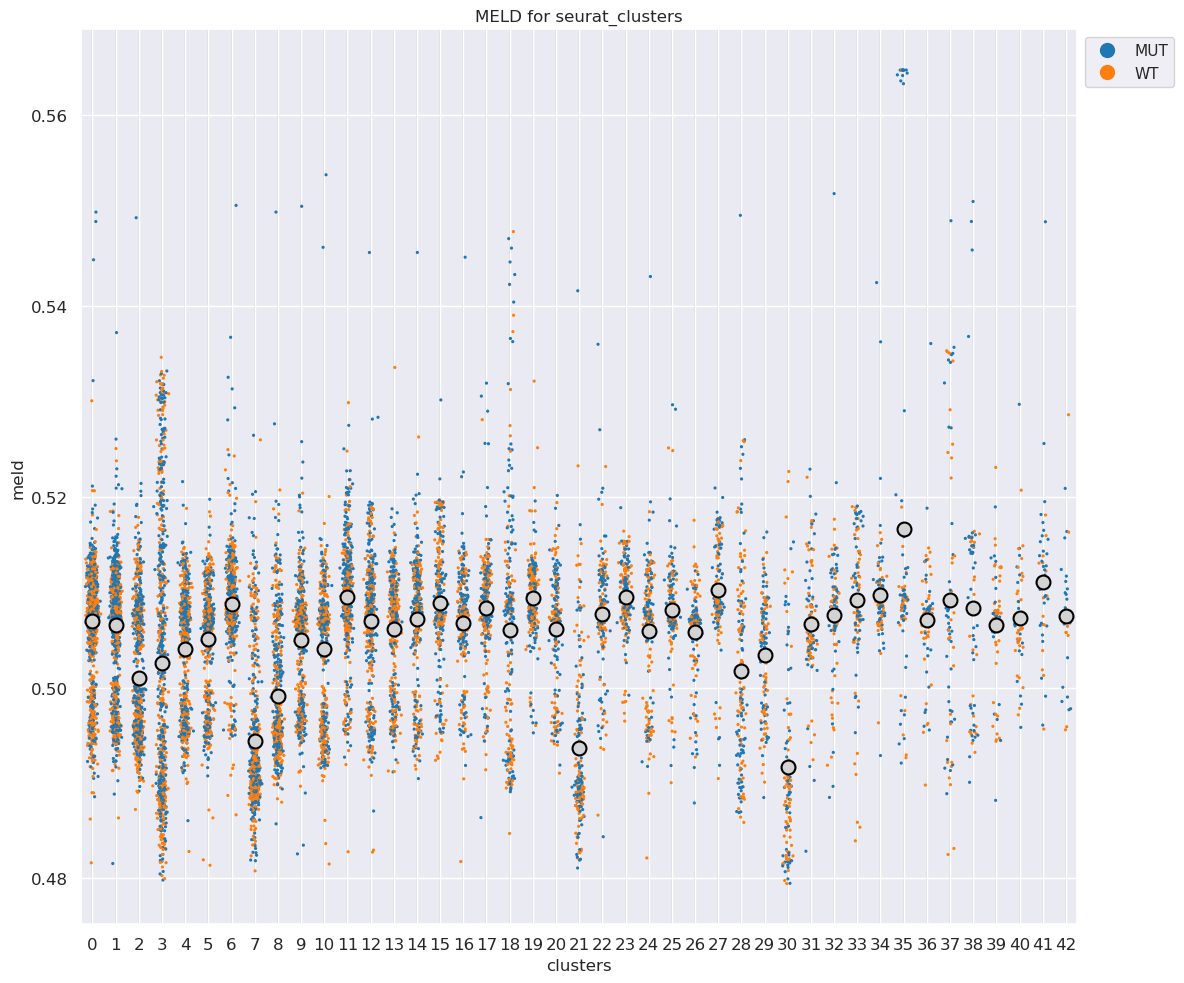

In [89]:
scprep.plot.jitter(df["clusters"], df["meld"], title='MELD for seurat_clusters', figsize=(12,10), c=df["sample"],
                  legend_anchor=(1,1), filename='../zebrafish/img/MELD_for_seurat_clusters.png', dpi=150)

In [90]:
df = df.drop(df[df['clusters'].isin([2, 4, 5, 6, 9, 40])].index)

<AxesSubplot:title={'center':'MELD for seurat_clusters'}, xlabel='clusters', ylabel='meld'>

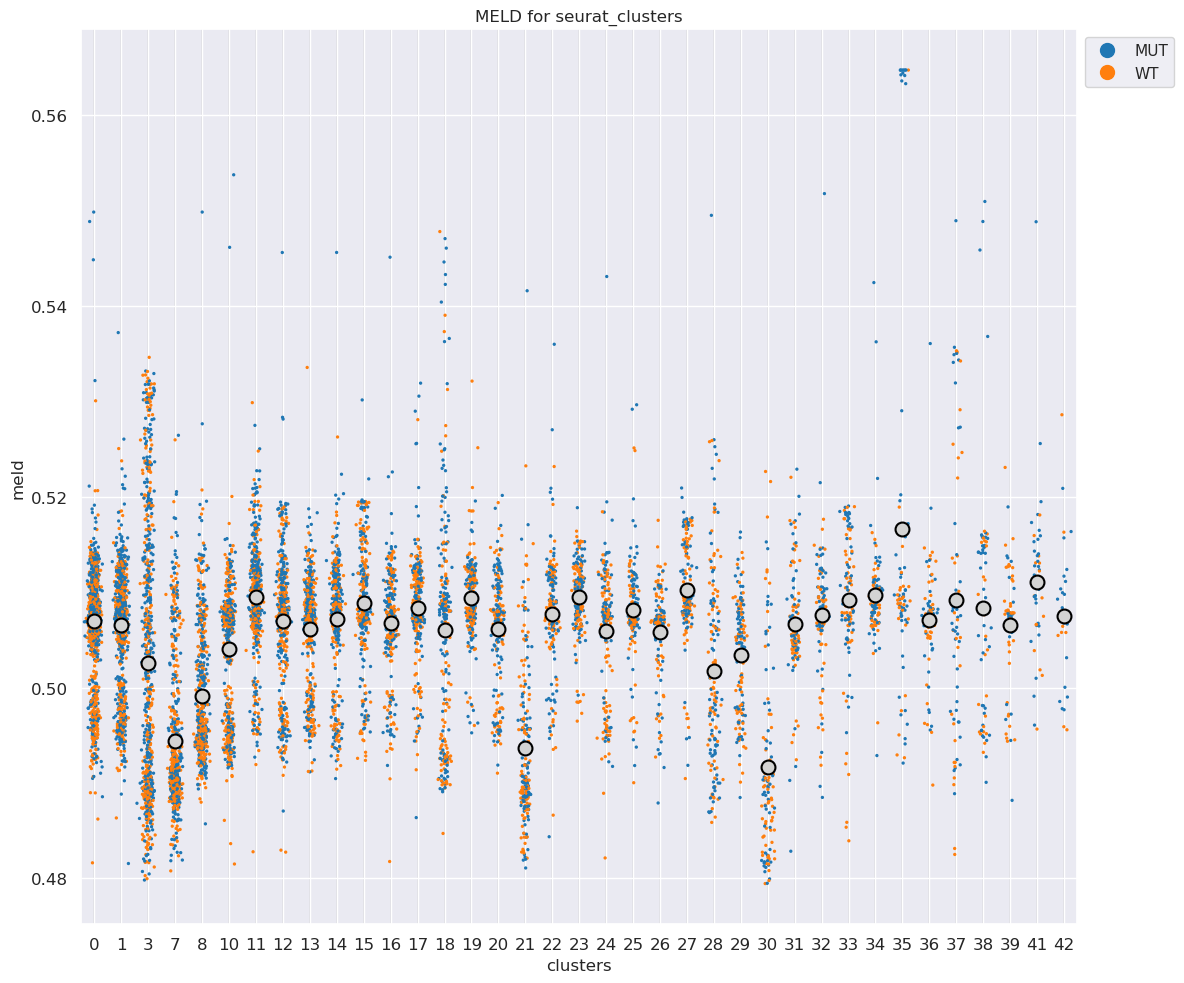

In [91]:
scprep.plot.jitter(df["clusters"], df["meld"], title='MELD for seurat_clusters', figsize=(12,10), c=df["sample"],
                  legend_anchor=(1,1), filename='../zebrafish/img/MELD_for_seurat_clusters_no_unknown.png', dpi=150)

In [92]:
df = df.replace({'cond_clusters': {28: 3, 33: 17, 34: 17, 41: 17, 29: 17, 23: 21, 24: 13, 25: 13, 31: 27, 39: 27, 26: 10, 22: 16}})
df = df.replace({'cond_clusters': {0: 'neurons_glutamatergic', 1: 'mid-hind boundary_GABAergic', 2: 'radial glia', 3: 'radial glia', 7: 'progenitors/neurons_differentiating', 8: 'granule cells', 10: 'optic tectum_GABAergic', 11: 'neurons_broad', 12: 'GABAergic neurons', 13: 'neurons_midbrain, glutamatergic', 14: 'telencephalon_glutamatergic', 15: 'hindbrain', 16: 'dorsal diencephalon_thalamus', 17: 'hypothalamus', 18: 'dead/dying', 19: 'neurons_telencephalon', 20: 'cranial ganglion_vagal', 21: 'ventral forebrain_dienc, hyp, poa: GABAergic', 27: 'dorsal habenula', 30: 'glial progenitors', 32: 'dorsal telencephalon_glutamatergic', 35: 'oligodendryocyte progenitor cells', 36: 'habenula/hindbrain, motor neurons', 37: 'microglia', 38: 'Purkinje neurons_GABAergic++', 42: 'ventral habenula'}})


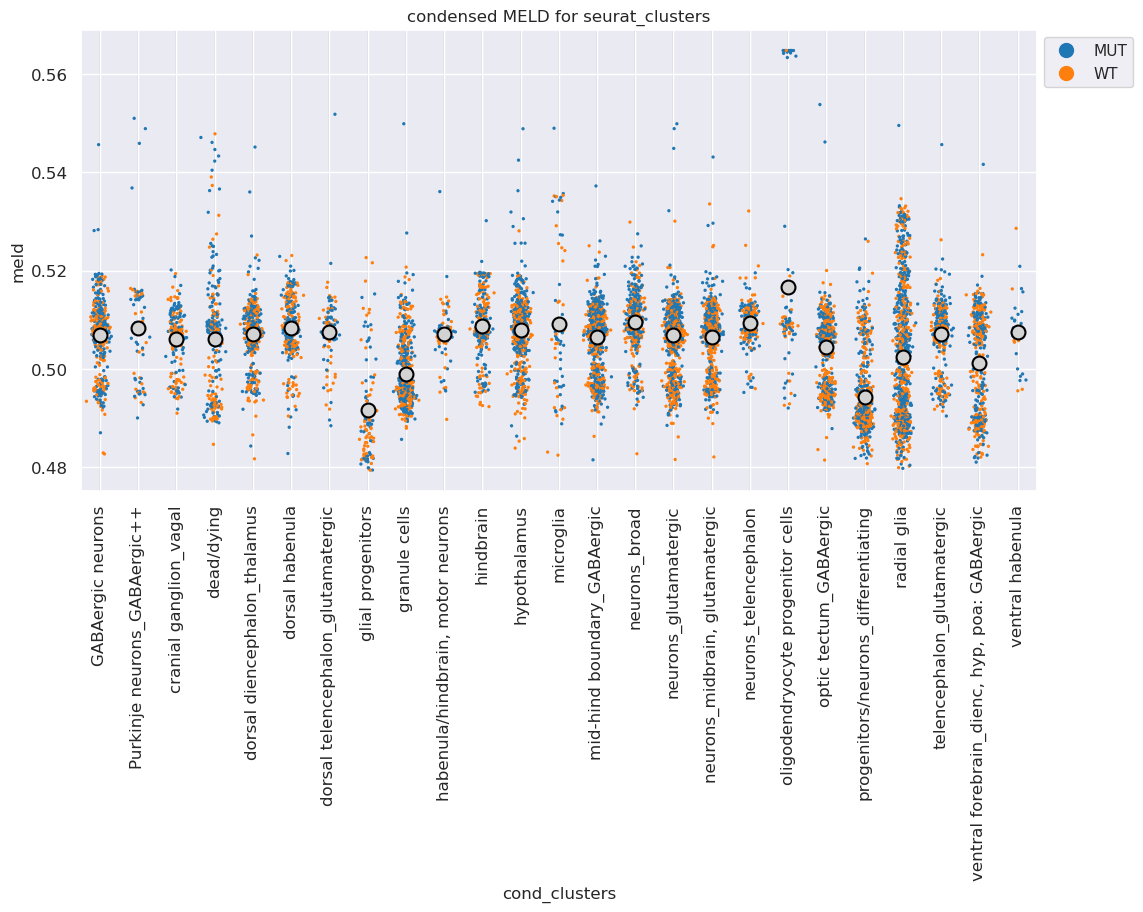

In [93]:
ax = scprep.plot.jitter(df["cond_clusters"], df["meld"], title='condensed MELD for seurat_clusters', figsize=(12,10), c=df["sample"],
                  legend_anchor=(1,1))
plt.xticks(rotation=90) 
plt.gcf().subplots_adjust(bottom=0.50)
plt.savefig('../zebrafish/img/condensed_MELD_for_seurat_clusters.png', dpi=150)


In [71]:
d = {'i_phate': i_phate.tolist(), 'cond_clusters': rna_adata2.obs[2]}
df = pd.DataFrame(data=d)
df


i_phate  \
AAACAGCCAAATATCC-1  [-0.009269548863120095, -0.004298888389588238,...   
AAACATGCAACTAGGG-1  [-0.008980608406181832, -0.004037320689095672,...   
AAACATGCAAGACTCC-1  [-0.009118634252221737, -0.004172313936322319,...   
AAACATGCATCGCTTT-1  [-0.007036517659340094, -0.0030716452012272727...   
AAACCAACAACTAACT-1  [-0.008585623447600343, -0.003917885239529784,...   
...                                                               ...   
TTTGTGTTCCTTGAGG-2  [-0.008483909457691957, -0.0038368130313490385...   
TTTGTGTTCGCTTGCT-2  [-0.007955909125922101, -0.0036551472772787617...   
TTTGTTGGTATTGGTG-2  [-0.0068132270949528085, -0.003093084162131259...   
TTTGTTGGTTAAGTGT-2  [0.006729022984527174, -0.00022853495033370042...   
TTTGTTGGTTGGTTGA-2  [0.0014775509031183488, -0.001416098477551933,...   

                    cond_clusters  
AAACAGCCAAATATCC-1              1  
AAACATGCAACTAGGG-1              9  
AAACATGCAAGACTCC-1             36  
AAACATGCATCGCTTT-1              2  
AAACCAACAACTAACT-1              0  
...                           ...  
TTTGTGTTCCTTGAGG-2              5  
TTTGTGTTCGCTTGCT-2             29  
TTTGTTGGTATTGGTG-2              2  
TTTGTTGGTTAAGTGT-2             21  
TTTGTTGGTTGGTTGA-2              3  

[14682 rows x 2 columns]

In [72]:
df = df.drop(df[df['cond_clusters'].isin([2, 4, 5, 6, 9, 40])].index)

In [73]:
df = df.replace({'cond_clusters': {28: 3, 33: 17, 34: 17, 41: 17, 29: 17, 23: 21, 24: 13, 25: 13, 31: 27, 39: 27, 26: 10, 22: 16}})
df = df.replace({'cond_clusters': {0: 'neurons_glutamatergic', 1: 'mid-hind boundary_GABAergic', 2: 'radial glia', 3: 'radial glia', 7: 'progenitors/neurons_differentiating', 8: 'granule cells', 10: 'optic tectum_GABAergic', 11: 'neurons_broad', 12: 'GABAergic neurons', 13: 'neurons_midbrain, glutamatergic', 14: 'telencephalon_glutamatergic', 15: 'hindbrain', 16: 'dorsal diencephalon_thalamus', 17: 'hypothalamus', 18: 'dead/dying', 19: 'neurons_telencephalon', 20: 'cranial ganglion_vagal', 21: 'ventral forebrain_dienc, hyp, poa: GABAergic', 27: 'dorsal habenula', 30: 'glial progenitors', 32: 'dorsal telencephalon_glutamatergic', 35: 'oligodendryocyte progenitor cells', 36: 'habenula/hindbrain, motor neurons', 37: 'microglia', 38: 'Purkinje neurons_GABAergic++', 42: 'ventral habenula'}})


<Axes3DSubplot:title={'center':'integrated PHATE of cond_clusters'}, xlabel='integrated PHATE1', ylabel='integrated PHATE2'>

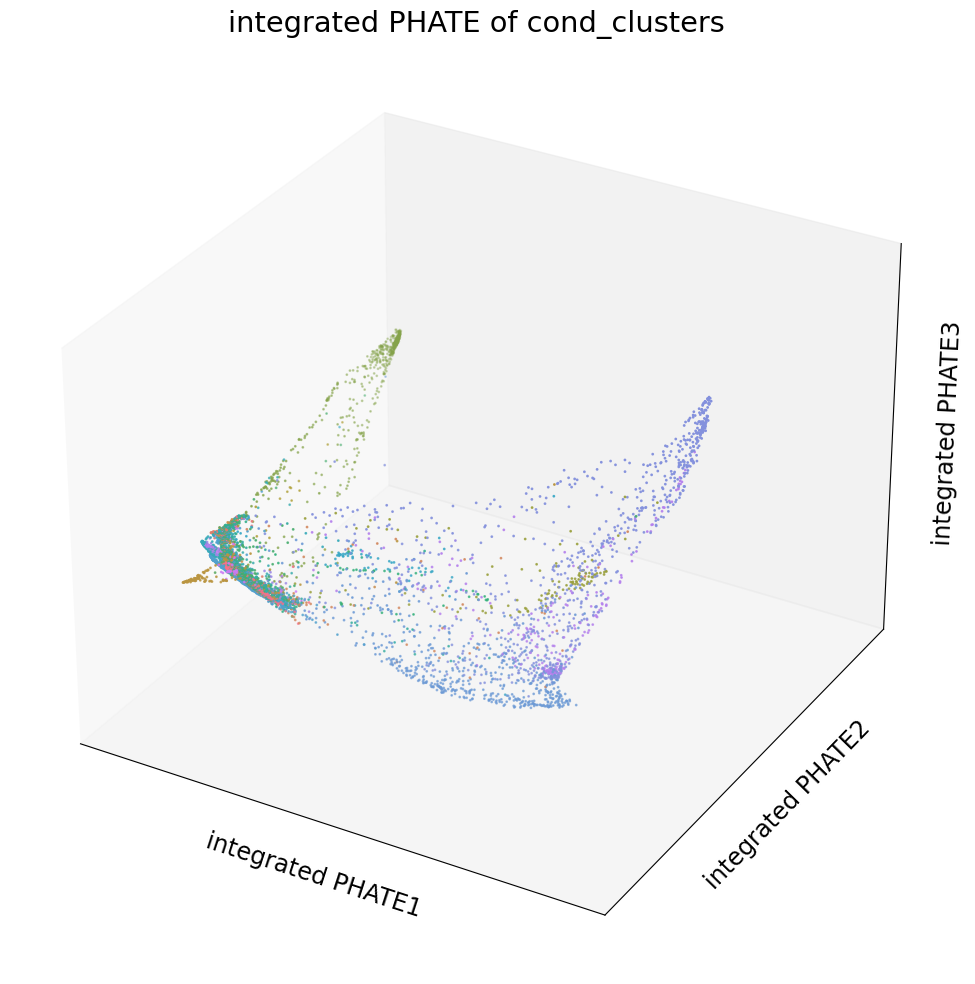

In [77]:
scprep.plot.scatter3d(df["i_phate"].tolist(), c=df["cond_clusters"].tolist(), cmap=sns.husl_palette(5), s=1,
                      figsize=(12,10), ticks=None, label_prefix='integrated PHATE',
                     legend=False, fontsize=12, title='integrated PHATE of cond_clusters',
                     filename='../zebrafish/img/integrated_PHATE_of_cond_clusters.png', dpi=150)


### Differential expression

In [100]:
# removing rpl/rps genes from rna_adata

non_ribosomal_genes_list = [name for name in rna_adata.var_names if not name.startswith('rpl')]
adata_no_ribosomal_genes = rna_adata[:, non_ribosomal_genes_list]
non_ribosomal_genes_list = [name for name in adata_no_ribosomal_genes.var_names if not name.startswith('rps')]
adata_no_ribosomal_genes = adata_no_ribosomal_genes[:, non_ribosomal_genes_list]
non_ribosomal_genes_list = [name for name in adata_no_ribosomal_genes.var_names if not name.startswith('RPL')]
adata_no_ribosomal_genes = adata_no_ribosomal_genes[:, non_ribosomal_genes_list]
non_ribosomal_genes_list = [name for name in adata_no_ribosomal_genes.var_names if not name.startswith('RPS')]
adata_no_ribosomal_genes = adata_no_ribosomal_genes[:, non_ribosomal_genes_list]
non_ribosomal_genes_list = [name for name in adata_no_ribosomal_genes.var_names if not name.startswith('mrpl')]
adata_no_ribosomal_genes = adata_no_ribosomal_genes[:, non_ribosomal_genes_list]
non_ribosomal_genes_list = [name for name in adata_no_ribosomal_genes.var_names if not name.startswith('mrps')]
adata_no_ribosomal_genes = adata_no_ribosomal_genes[:, non_ribosomal_genes_list]
non_ribosomal_genes_list = [name for name in adata_no_ribosomal_genes.var_names if not name.startswith('MRPL')]
adata_no_ribosomal_genes = adata_no_ribosomal_genes[:, non_ribosomal_genes_list]
non_ribosomal_genes_list = [name for name in adata_no_ribosomal_genes.var_names if not name.startswith('MRPS')]
adata_no_ribosomal_genes = adata_no_ribosomal_genes[:, non_ribosomal_genes_list]

In [101]:
import diffxpy.api as de
results = de.test.rank_test(adata_no_ribosomal_genes, grouping=clusters)

In [102]:
results = results.summary().set_index('gene').sort_values('qval')
results

pval          qval    log2fc      mean  zero_mean  \
gene                                                                          
kcnj11l-1         1.754509e-56  2.423153e-52  8.569837  0.489904      False   
si:ch211-132g1.3  4.009870e-52  2.769016e-48  5.443583  0.538053      False   
si:dkey-205h13.1  5.196756e-41  2.392413e-37  4.781122  0.494492      False   
cx27.5            1.299548e-33  3.589612e-30  7.389520  0.217765      False   
zcchc24           1.178381e-33  3.589612e-30  7.631411  0.226939      False   
...                        ...           ...       ...       ...        ...   
si:dkey-234i14.3           NaN           NaN  0.000000  0.000000       True   
si:dkey-234i14.6           NaN           NaN  0.000000  0.000000       True   
trim44                     NaN           NaN  0.000000  0.000000       True   
chmp1a                     NaN           NaN  0.000000  0.000000       True   
mt-nd4l                    NaN           NaN  0.000000  0.000000       True   

                  zero_variance  
gene                             
kcnj11l-1                 False  
si:ch211-132g1.3          False  
si:dkey-205h13.1          False  
cx27.5                    False  
zcchc24                   False  
...                         ...  
si:dkey-234i14.3           True  
si:dkey-234i14.6           True  
trim44                     True  
chmp1a                     True  
mt-nd4l                    True  

[16947 rows x 6 columns]

In [103]:
results.to_csv('../diffexp.integrated_clusters.wilcoxon.csv')

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
... storing 'integrated_clusters' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


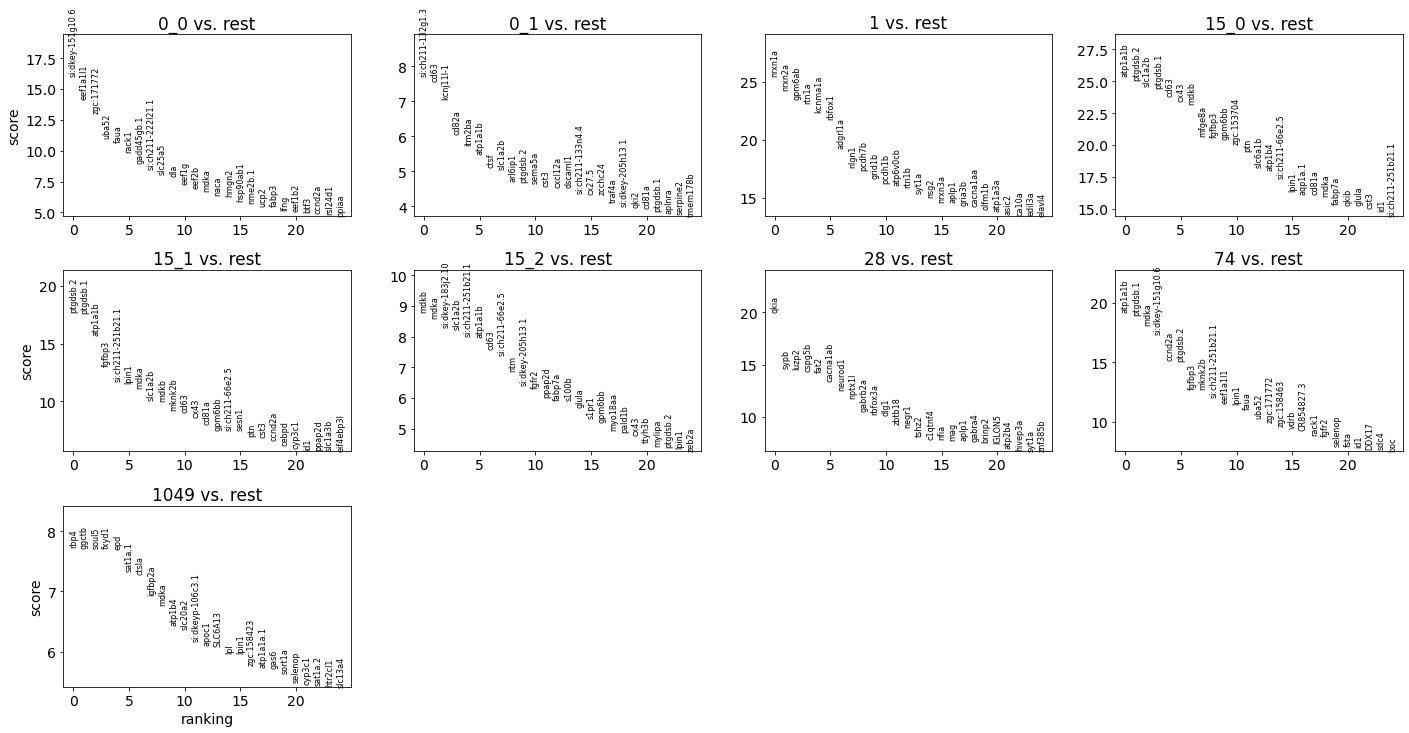

In [104]:
adata_no_ribosomal_genes.obs['integrated_clusters'] = clusters
sc.tl.rank_genes_groups(adata_no_ribosomal_genes, 'integrated_clusters', method='wilcoxon')
sc.pl.rank_genes_groups(adata_no_ribosomal_genes, n_genes=25, sharey=False, save='.png')

In [105]:
ranked_genes_by_cluster = pd.DataFrame(adata_no_ribosomal_genes.uns['rank_genes_groups']['names']).loc[0:10]

In [106]:
ranked_genes_by_cluster.to_csv('../zebrafish/figures/rank_genes_groups_integrated_clusters.csv')

### CATCH

In [32]:
# powered condensation
def comp(node, neigh, visited):
    """Short summary.
    Parameters
    ----------
    node : type
        Description of parameter `node`.
    neigh : type
        Description of parameter `neigh`.
    visited : type
        Description of parameter `visited`.
    Returns
    -------
    type
        Description of returned object.
    """
    vis = visited.add
    nodes = set([node])
    next_node = nodes.pop
    while nodes:
        node = next_node()
        vis(node)
        nodes |= neigh[node] - visited
        yield node
def merge_common(lists):
    """Short summary.
    Parameters
    ----------
    lists : type
        Description of parameter `lists`.
    Returns
    -------
    type
        Description of returned object.
    """
    neigh = collections.defaultdict(set)
    visited = set()
    for each in lists:
        for item in each:
            neigh[item].update(each)
    for node in neigh:
        if node not in visited:
            yield sorted(comp(node, neigh=neigh, visited=visited))
            
def compute_optimal_t(diff_op, t_max):
    t = np.arange(t_max)
    h = vne.compute_von_neumann_entropy(diff_op, t_max=t_max)
    return vne.find_knee_point(y=h, x=t)

def compress_data(X, n_pca = 50, random_state=None):
    pca_op = sklearn.decomposition.PCA(n_components=n_pca, random_state=random_state)
    return pca_op.fit_transform(X)
    
def condese_vne_adaptive(X, knn = 5, n_jobs=1, t = 'auto', t_max = 50, random_state=None):
    if X.shape[0] > 2000:
        n_landmarks = 1000
    else:
        n_landmarks = None
    G = graphtools.Graph(
        X, n_pca = None,
        knn=min(X.shape[0] - 2, knn),
        n_jobs=n_jobs, n_landmark = n_landmarks,
        random_state=random_state,
    )
    
    P_s = G.P.toarray()
    if n_landmarks == None:
        if t == 'auto' and t_max > 2:
            t = compute_optimal_t(P_s, t_max)
        #print(t)
        P_s = np.linalg.matrix_power(P_s, t)
        return P_s @ X, P_s, G.K.toarray(), t
    else:
        if t == 'auto' and t_max > 2:
            t = compute_optimal_t(G.landmark_op, t_max)
        #print(t)
        G_pl = G.transitions
        G_lp = G._data_transitions()
        P_s = G_pl@np.linalg.matrix_power(G.landmark_op, t)@G_lp
        return P_s @ X, P_s, G.K.toarray(), t
    
    
def condese_fixed(X, epsilon, t = 10, n_jobs=1, random_state=None):
    if X.shape[0] > 5000:
        n_landmarks = 1000
    else:
        n_landmarks = None
    G = graphtools.Graph(
        X, n_pca = None,
        bandwidth=epsilon,
        n_jobs=n_jobs, n_landmark = n_landmarks,
        random_state=random_state
    )
    
    if n_landmarks == None:
        P_s = G.P.toarray()
        P_s = np.linalg.matrix_power(P_s, t)
        return P_s @ X, P_s, G.K.toarray()
    else:
        G_pl = G.transitions
        G_lp = G._data_transitions()
        P_s = G.landmark_op
        P_s = G_pl@np.linalg.matrix_power(P_s, t)@G_lp
        return P_s @ X, P_s, G.K.toarray()

def compute_merges(X, merge_threshold, n_jobs=1):
    D = pdist(X, metric='euclidean')
    D = squareform(D)
    
    bool_ = D < merge_threshold
    loc = np.where(bool_)
    merge_pairs = []
    for i in range(len(loc[0])):
        if loc[0][i] != loc[1][i]:
            merge_pairs.append(tuple([loc[0][i], loc[1][i]]))
    return merge_pairs

def compute_merge_threshold(X, n_jobs=1):
    """Short summary.
    Parameters
    ----------
    X : type
        Description of parameter `X`.
    granularity : type
        Description of parameter `granularity`.
    Returns
    -------
    type
        Description of returned object.
    """
    D = pdist(X, metric='euclidean')
    merge_threshold = np.percentile(D, 0.01) + 1e-7
    return merge_threshold

# powered condensation
def comp(node, neigh, visited):
    """Short summary.
    Parameters
    ----------
    node : type
        Description of parameter `node`.
    neigh : type
        Description of parameter `neigh`.
    visited : type
        Description of parameter `visited`.
    Returns
    -------
    type
        Description of returned object.
    """
    vis = visited.add
    nodes = set([node])
    next_node = nodes.pop
    while nodes:
        node = next_node()
        vis(node)
        nodes |= neigh[node] - visited
        yield node
def merge_common(lists):
    """Short summary.
    Parameters
    ----------
    lists : type
        Description of parameter `lists`.
    Returns
    -------
    type
        Description of returned object.
    """
    neigh = collections.defaultdict(set)
    visited = set()
    for each in lists:
        for item in each:
            neigh[item].update(each)
    for node in neigh:
        if node not in visited:
            yield sorted(comp(node, neigh=neigh, visited=visited))

def condensation_fixed_t(data, n_pca = 50, t = 1, granularity = 1, scale = 1.025,
                         n_jobs = 1, random_state=None):
    if n_pca != None and data.shape[0] > n_pca:
        with tasklogger.log_task("PCA"):
            X = compress_data(data, n_pca=n_pca, random_state=random_state)
    else:
        X = data

    N = X.shape[0]
    NxT = []
    clusters = np.arange(N)
    NxT.append(clusters)
    NxT.append(clusters)

    X_2 = X.copy()
    K_list = []
    X_list = []
    X_list.append(X_2)
    X_list.append(X_2)
    P_list = []
    merged = []
        
    with tasklogger.log_task("Condensation Parameters"):
        merge_threshold = compute_merge_threshold(X_2, n_jobs=n_jobs)

        print('Setting Merge Threshold to '+str(round(merge_threshold,4)))
        merge_pairs = compute_merges(X_2, merge_threshold, n_jobs=n_jobs)
        merge_pairs = list(merge_common(merge_pairs))
        #print(len(merge_pairs))
        merged.append(merge_pairs)

        X_1, cluster_assignment = complete_merges(X_2, merge_pairs, NxT[-1])

        epsilon=granularity*(.1*np.mean(np.std(X_1)))/(X_1.shape[0]**(-1/5))

        print('Setting Epislon to '+str(round(epsilon,4)))

        del X_list[-1]
        X_list.append(X_1)
        del NxT[-1]
        NxT.append(cluster_assignment)
    
    with tasklogger.log_task("Condensation"):
        while X_1.shape[0] > 1:
            epsilon = epsilon * scale

            X_2, P_s, K_2 = condese_fixed(X_1, epsilon=epsilon, t = t,
                                          n_jobs=n_jobs, random_state=random_state)
            X_list.append(X_1)
            P_list.append(P_s)
            NxT.append(NxT[-1].copy())
            K_list.append(K_2)

            merge_pairs = compute_merges(X_2, merge_threshold, n_jobs=n_jobs)
            merge_pairs = list(merge_common(merge_pairs))
            merged.append(merge_pairs)

            X_1, cluster_assignment = complete_merges(X_2, merge_pairs, NxT[-1])

            del X_list[-1]
            X_list.append(X_1)
            del NxT[-1]
            NxT.append(cluster_assignment)
            
    return NxT, X_list, K_list, merged, P_list

def complete_merges(X_1, merge_pairs, cluster_assignment):
    clusters_uni = np.unique(cluster_assignment)
    to_delete = []
    for m in range(len(merge_pairs)):
        to_merge = merge_pairs[m]
        X_1[to_merge[0]] = np.mean(X_1[to_merge], axis=0)
        to_delete.extend(to_merge[1:])
        for c in to_merge[1:]:
            cluster_assignment[cluster_assignment==clusters_uni[c]] = cluster_assignment[clusters_uni[to_merge[0]]]
    X_1 = np.delete(X_1, to_delete, axis=0)
    return X_1, cluster_assignment

In [35]:
import numpy as np
import pandas as pd
import graphtools
from CATCH import catch
import matplotlib.pyplot as plt
import scprep

import phate
import sklearn

import tasklogger
import collections
import warnings
from collections import defaultdict

from scipy.spatial.distance import pdist, cdist, squareform
warnings.simplefilter("ignore")

In [55]:
def transform(NxTs):
        with tasklogger.log_task("Topological Activity"):
            ind_components = []

            for c in range(len(NxTs)):
                ind_components.append(len(np.unique(NxTs[c])))
            ind_components = np.array(ind_components)
            gradient = np.diff(np.log(ind_components))
            locs = np.where(gradient == 0)[0]
            res = []
            for c in range(1, len(locs)):
                if ind_components[locs[c]] - ind_components[locs[c - 1]] != 0:
                    res.append(locs[c])
            levels = np.array(res) - len(NxTs)
        return levels

In [173]:
import condense as cond

In [174]:
ep, merge_thresh = cond.compute_condensation_param(np.log10(i_diff_op), granularity=.1)

Setting epsilon to 0.0434
Setting merge threshold to 0.6674


In [36]:
NxTs, Xs, Ks, merges, Ps = condensation_fixed_t(np.log10(i_diff_op), scale=1.025, t=1, n_pca=20)

Calculating PCA...
Calculated PCA in 1.72 seconds.
Calculating Condensation Parameters...
Setting Merge Threshold to 0.9436
Setting Epislon to 7.1604
Calculated Condensation Parameters in 1.55 seconds.
Calculating Condensation...
Calculated Condensation in 21.23 seconds.


In [56]:
levels = transform(NxTs)

Calculating Topological Activity...
Calculated Topological Activity in 0.01 seconds.


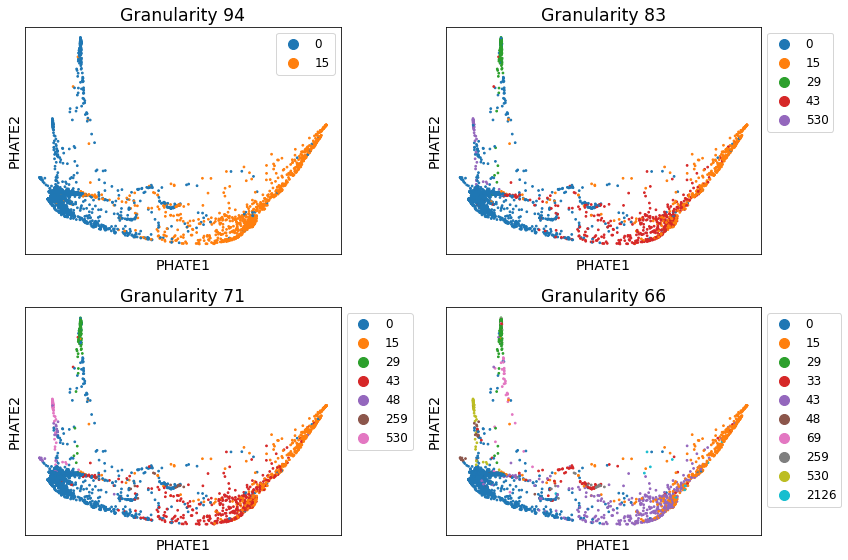

In [57]:
fig, axes = plt.subplots(2,2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):    
    scprep.plot.scatter2d(i_phate, c=NxTs[levels[-2*i-1]], legend_anchor=(1,1), ax=ax,
                          title='Granularity '+str(len(NxTs)+levels[-2*i-1]),
                          xticks=False, yticks=False, label_prefix="PHATE", fontsize=10, s=3)

fig.tight_layout()

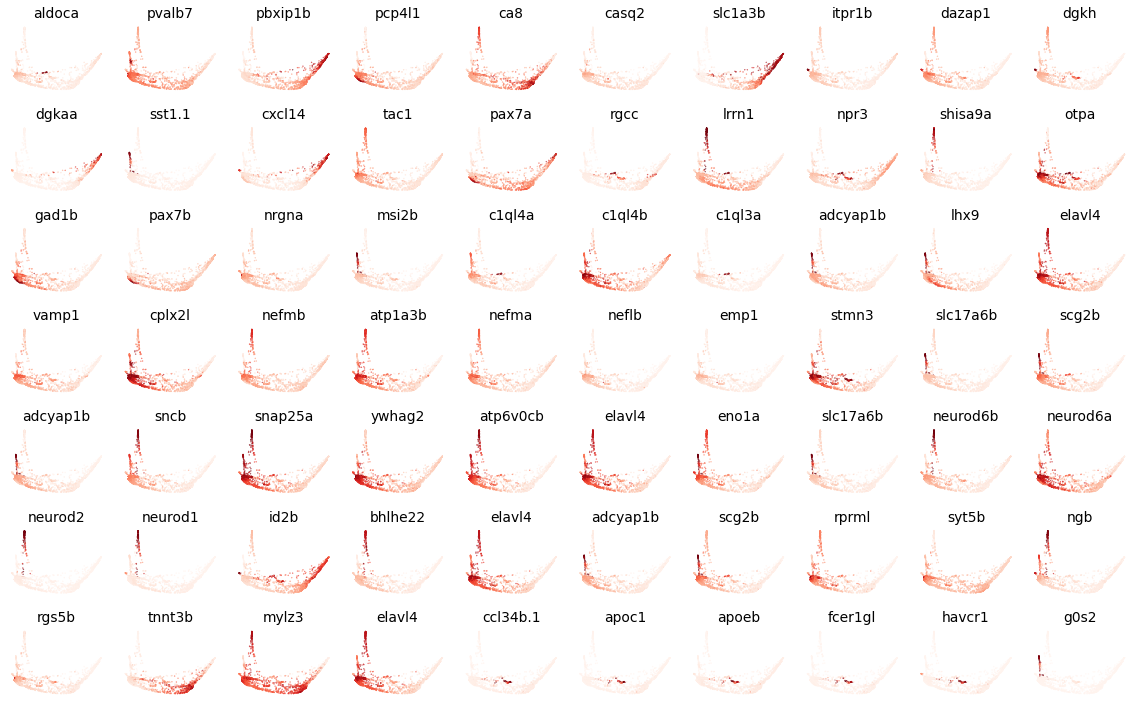

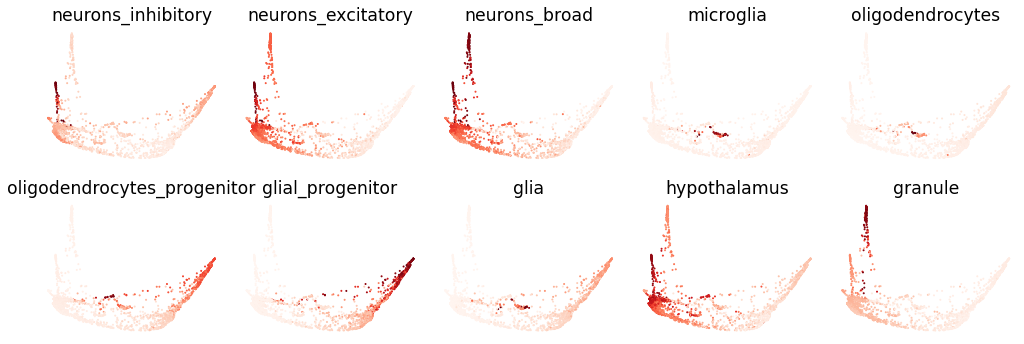

In [162]:
lineage = {}
lineage['neurons_inhibitory'] = ['aldoca', 'pvalb7', 'pbxip1b', 'pcp4l1', 'ca8', 'casq2', 'slc1a3b', 'itpr1b', 'dazap1', 'dgkh', 'dgkaa', 'sst1.1', 'cxcl14', 'tac1', 'pax7a', 'rgcc', 'lrrn1', 'npr3', 'shisa9a', 'otpa', 'gad1b', 'pax7b', 'nrgna', 'msi2b']
lineage['neurons_excitatory'] = ['c1ql4a', 'c1ql4b', 'c1ql3a', 'adcyap1b', 'lhx9', 'elavl4', 'vamp1', 'cplx2l', 'nefmb', 'atp1a3b', 'nefma', 'neflb', 'emp1', 'stmn3', 'slc17a6b', 'scg2b', 'adcyap1b', 'sncb', 'snap25a', 'ywhag2', 'atp6v0cb', 'elavl4', 'eno1a', 'slc17a6b']
lineage['neurons_broad'] = ['neurod6b', 'neurod6a', 'neurod2', 'neurod1', 'id2b', 'bhlhe22', 'elavl4', 'adcyap1b', 'scg2b', 'rprml', 'syt5b', 'ngb', 'rgs5b', 'tnnt3b', 'mylz3', 'elavl4']
lineage['microglia'] = ['ccl34b.1', 'apoc1', 'apoeb', 'fcer1gl', 'havcr1', 'g0s2']
lineage['oligodendrocytes'] = ['rgcc', 'scn4ab', 'phlda2', 'tuba8l3', 'sox10', 'krt8', 'hbegfb', 'hepacama', 'mbpa', 'mbpa', 'cd59', 'mbpb', 'plp1b', 'cldnk', 'cldn19', 'pmp22b', 'elovl1b', 'cx27.5', 'egr2b']
lineage['oligodendrocytes_progenitor'] = ['olig2', 'aplnrb', 'olig1', 'sema5a', 'cd82a', 'aplnra', 'traf4a', 'cd63', 'kcnj11l']
lineage['glial_progenitor'] = ['fabp7b', 'fabp7a', 'prss35', 'vim', 'wls', 's100b', 'msx3', 'cx43', 'hepacama', 's1pr1', 'ptgdsb.2', 'cx43', 'atp1b4', 'her4.1', 'fabp7a', 'mfge8a', 'atp1a1b', 'ptgdsb.1', 'ptn', 'her4.2-1', 'ptn', 'slc1a2b']
lineage['glia'] = ['epd', 'ggctb', 'soul5', 'fxyd1', 'igfbp2a', 'fabp11a', 'rbp4', 'mdka', 'cygb1', 'atp1b4', 'wu:fj16a03', 'fxyd1', 'bhmt', 'rbp4', 'cx43', 'igfbp2a', 'lpl', 'fabp11a', 'slc7a8a', 'epd', 'apof', 'lxn']
lineage['hypothalamus'] = ['pdyn', 'cbln1', 'kctd4', 'sox1b', 'nr0b1', 'fezf1', 'nr5a2', 'sox1a', 'avp', 'tac1', 'phlda2', 'prdx1', 'scgn', 'insm1b', 'txn', 'scg3', 'th2', 'nr4a1', 'mt2', 'chgb', 'egr2b', 'ccka', 'ak5l', 'tph1a', 'otpa', 'otpb', 'crhbp', 'bsx', 'trh', 'fezf1', 'scg2b', 'plk2b', 'rasd1', 'rgs5b', 'bhlhe41', 'cpne2', 'nts', 'bsx', 'htr1ab', 'nr4a2b', 'erv', 'scg2b', 'vat1', 'alcamb', 'gch1', 'isl1', 'txn', 'gata3', 'insm1b', 'tal1', 'tph2', 'txn', 'ddc', 'fev', 'gata2a', 'slc18a2', 'gata3', 'lmx1bb', 'htr1d', 'prdx1', 'penka', 'elavl4', 'oprl1', 'synpr', 'pyyb', 'sp8a', 'chodl', 'dlx2b', 'dlx1a', 'sall3a', 'dlx5a', 'tac1', 'dlx2a', 'oprd1b', 'gad2', 'gad1b']
lineage['granule'] = ['zic2a', 'neurod1', 'zic5', 'cspg5b', 'nebl', 'zic1', 'zbtb18', 'fat2', 'zic4', 'gsg1l', 'draxin', 'olfm2b', 'zic4', 'zic3', 'zic2b', 'elavl4', 'rtn1a', 'islr2', 'atp6v0cb', 'tcf7l2']
lineage['ventral_forebrain'] = ['dlx5a', 'dlx2a', 'gad2', 'dlx6a', 'lhx6', 'vax1', 'gad1b', 'dlx1a', 'islr2', 'slc32a1', 'slc6a1b', 'necab1', 'gsx1', 'nkx2.4a', 'nkx2.4b', 'oprd1b', 'tac1', 'prox1a', 'nrgna', 'prkcbb', 'ccka', 'rgs5b']
lineage['dorsal_telencephalon'] = ['tac3b', 'tbr1b', 'gabrr2b', 'parietopsin', 'nmbb', 'emx3', 'grm2a', 'apof', 'p2rx3b', 'pawr', 'mdm2', 'prex1', 'slc17a6a', 'rtn4rl2b', 'rtn4rl2a', 'nrgna', 'itm2cb', 'bhlhe22', 'eomesa', 'egr3', 'draxin', 'zbtb18', 'egr2b', 'neurod6a', 'tbr1b', 'tbr1b', 'eomesa', 'emx3', 'draxin', 'neurod6b', 'slc17a6a', 'islr2', 'fezf1', 'pdyn', 'rasd1', 'syt5b', 'cpne2', 'foxg1a', 'nrgna', 'kctd12.2', 'ngb', 'cyth4a', 'syt9b', 'ppp1r1c', 'prkcbb', 'camk2a', 'iqsec2b', 'raver2', 'cntln', 'lrmp', 'add3b', 'pvalb7', 'nrgna', 'shox2']
lineage['midbrain'] = ['atf5b', 'ddit3', 'cebpa', 'atf5a', 'hunk', 'sox4a-1', 'gadd45ga', 'sox11a', 'lhx9', 'barhl2', 'hunk', 'mab21l2', 'ddit3', 'mycn', 'lhx4', 'nkx6.1', 'shox2', 'shox', 'snap25a', 'pou3f1', 'meis3', 'esrrga', 'elavl4', 'tmie', 'calb2a', 'cbln1', 'pax2a', 'c1ql4b', 'ebf3a', 'lhx9', 'neurod6b', 'slc17a6a']
lineage['hindbrain'] = ['phox2bb', 'phox2a', 'lmx1bb', 'drgx', 'tlx2', 'lbx2', 'shox2', 'cbln1', 'hoxb5a', 'hoxb5b', 'hoxc5a', 'hoxb6a', 'hoxb6b', 'hoxd4a', 'hoxc3a', 'hoxb3a']
lineage['habenula'] = ['gng8', 'kctd12.1', 'cnih3', 'synpr', 'nwd2', 'pou4f1', 'pdyn', 'ano2b', 'cpne4b', 'zic5', 'nr4a3', 'kiss1', 'prkcq', 'prox1a', 'aoc1', 'csrp2', 'wnt11', 'nts', 'ak5', 'tac3a', 'gng8', 'g0s2', 'sst1.1', 'synpr', 'cnih3', 'nrn1a', 'zic3', 'kctd4', 'pou4f1', 'kctd12.1', 'syt9b']

##

all_genes = []
for k in lineage.keys():
    all_genes.extend(lineage[k])
    
rna_data = pd.DataFrame(rna_adata.X.toarray())
rna_data.columns = rna_adata.var.index

rna_data_sub = scprep.normalize.batch_mean_center(scprep.select.select_cols(rna_data, exact_word=all_genes))

rna_data_smoothed = i_diff_op@rna_data_sub

import matplotlib.pyplot as plt

fig, axes = plt.subplots(7,10, figsize=(16, 10))

for i, ax in enumerate(axes.flatten()):
    
    exp = pd.DataFrame(scprep.select.select_cols(rna_data_smoothed, exact_word=all_genes[i]))
    
    if exp.shape[1] >0:
        scprep.plot.scatter2d(i_phate, c= np.array(exp), ax=ax,
                              title=all_genes[i], legend = False,
                              xticks=False, yticks=False, label_prefix=None, fontsize=8, s=.1, cmap = 'Reds')
    ax.set_axis_off()
fig.tight_layout()

composite_lineage = {}

for i in np.array(list(lineage.keys())):
    expression = pd.DataFrame(scprep.select.select_cols(rna_data_smoothed, exact_word=lineage[i]))
    composite_lineage[i] = np.sum(expression, axis=1)

fig, axes = plt.subplots(2,5, figsize=(14, 5))

for i, ax in enumerate(axes.flatten()):
    exp = composite_lineage[list(composite_lineage.keys())[i]]
    scprep.plot.scatter2d(i_phate, c=exp, ax=ax,
                          title=list(composite_lineage.keys())[i], legend = False,
                          xticks=False, yticks=False, label_prefix=None, fontsize=10, s=1, cmap = 'Reds')
    ax.set_axis_off()

fig.tight_layout()

In [161]:
rna_data = pd.DataFrame(rna_adata.X.toarray())
rna_data.columns = rna_adata.var.index

scprep.normalize.batch_mean_center(scprep.select.select_cols(rna_data, exact_word=all_genes))

ptn     csrp2      ano2b      lrmp       th2      pawr      mdm2  \
0    -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   
1    -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   
2    -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   
3    -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   
4    -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   
...       ...       ...        ...       ...       ...       ...       ...   
7745 -0.35326 -0.069247  12.217137 -0.003016 -0.018163 -0.043301 -0.051481   
7746 -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   
7747 -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   
7748 -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   
7749 -0.35326 -0.069247  -0.154653 -0.003016 -0.018163 -0.043301 -0.051481   

         gata3     prkcq   slc7a8a  ...   pvalb7   kcnj11l     tph1a  \
0    -0.111563 -0.009504 -0.243707  ... -0.04731 -0.058788 -0.017266   
1    -0.111563 -0.009504 -0.243707  ... -0.04731  5.161169 -0.017266   
2    -0.111563 -0.009504  5.211740  ... -0.04731 -0.058788 -0.017266   
3    -0.111563 -0.009504 -0.243707  ... -0.04731 -0.058788 -0.017266   
4    -0.111563 -0.009504 -0.243707  ... -0.04731 -0.058788 -0.017266   
...        ...       ...       ...  ...      ...       ...       ...   
7745 -0.111563 -0.009504 -0.243707  ... -0.04731 -0.058788 -0.017266   
7746 -0.111563 -0.009504 -0.243707  ... -0.04731 -0.058788 -0.017266   
7747 -0.111563 -0.009504 -0.243707  ... -0.04731 -0.058788 -0.017266   
7748 -0.111563 -0.009504 -0.243707  ... -0.04731 -0.058788 -0.017266   
7749 -0.111563 -0.009504 -0.243707  ... -0.04731 -0.058788 -0.017266   

         syt9b  parietopsin     islr2    phlda2     fezf1  slc17a6a   slc1a2b  
0    -0.092574    -0.004237  7.522430 -0.005647 -0.011602  -0.28627 -1.093520  
1    -0.092574    -0.004237 -1.052499 -0.005647 -0.011602  -0.28627 -1.093520  
2    -0.092574    -0.004237 -1.052499 -0.005647 -0.011602  -0.28627 -1.093520  
3    -0.092574    -0.004237 -1.052499 -0.005647 -0.011602  -0.28627 -1.093520  
4    -0.092574    -0.004237 -1.052499 -0.005647 -0.011602  -0.28627 -1.093520  
...        ...          ...       ...       ...       ...       ...       ...  
7745 -0.092574    -0.004237 -1.052499 -0.005647 -0.011602  -0.28627 -1.093520  
7746 -0.092574    -0.004237 -1.052499 -0.005647 -0.011602  -0.28627 -1.093520  
7747 -0.092574    -0.004237 -1.052499 -0.005647 -0.011602  -0.28627 -1.093520  
7748 -0.092574    -0.004237 -1.052499 -0.005647 -0.011602  -0.28627 -1.093520  
7749 -0.092574    -0.004237  1.975025 -0.005647 -0.011602  -0.28627  3.188046  

[7750 rows x 287 columns]

In [156]:
rna_adata.var.T

phtf2             phtf2-1  \
gene_ids               ENSDARG00000102123  ENSDARG00000114503   
feature_types             Gene Expression     Gene Expression   
genome                             grcz11              grcz11   
mt                                  False               False   
n_cells_by_counts                      24                  67   
mean_counts                       0.00002            0.000056   
pct_dropout_by_counts           99.998021           99.994475   
total_counts                         24.0                68.0   
n_cells                                 7                  19   

                                   mansc1                lrp6  \
gene_ids               ENSDARG00000104839  ENSDARG00000100143   
feature_types             Gene Expression     Gene Expression   
genome                             grcz11              grcz11   
mt                                  False               False   
n_cells_by_counts                      94                  15   
mean_counts                      0.000079            0.000012   
pct_dropout_by_counts           99.992248           99.998763   
total_counts                         96.0                15.0   
n_cells                                27                   7   

                                   dusp16              crebl2  \
gene_ids               ENSDARG00000102474  ENSDARG00000104049   
feature_types             Gene Expression     Gene Expression   
genome                             grcz11              grcz11   
mt                                  False               False   
n_cells_by_counts                      23                 137   
mean_counts                      0.000019            0.000117   
pct_dropout_by_counts           99.998103           99.988702   
total_counts                         23.0               142.0   
n_cells                                 9                  36   

                                    gpr19                tbk1  \
gene_ids               ENSDARG00000102226  ENSDARG00000103095   
feature_types             Gene Expression     Gene Expression   
genome                             grcz11              grcz11   
mt                                  False               False   
n_cells_by_counts                     543                 306   
mean_counts                      0.000462            0.000268   
pct_dropout_by_counts            99.95522           99.974765   
total_counts                        560.0               325.0   
n_cells                               151                  94   

                                    eps8a               ptpro  ...  \
gene_ids               ENSDARG00000102128  ENSDARG00000110470  ...   
feature_types             Gene Expression     Gene Expression  ...   
genome                             grcz11              grcz11  ...   
mt                                  False               False  ...   
n_cells_by_counts                      81                 116  ...   
mean_counts                       0.00007            0.000101  ...   
pct_dropout_by_counts            99.99332           99.990434  ...   
total_counts                         85.0               122.0  ...   
n_cells                                29                  42  ...   

                                   mt-co2             mt-atp8  \
gene_ids               ENSDARG00000063908  ENSDARG00000063910   
feature_types             Gene Expression     Gene Expression   
genome                             grcz11              grcz11   
mt                                   True                True   
n_cells_by_counts                   39074                 230   
mean_counts                      0.092478            0.000238   
pct_dropout_by_counts           96.777663           99.981032   
total_counts                     112139.0               288.0   
n_cells                              4337                  17   

                                  mt-atp6              mt-co3  \
gene_ids       

In [74]:
rna_adata.var_names

Index(['phtf2', 'phtf2-1', 'mansc1', 'lrp6', 'dusp16', 'crebl2', 'gpr19',
       'tbk1', 'eps8a', 'ptpro',
       ...
       'mt-co2', 'mt-atp8', 'mt-atp6', 'mt-co3', 'mt-nd3', 'mt-nd4l', 'mt-nd4',
       'mt-nd5', 'mt-nd6', 'mt-cyb'],
      dtype='object', length=17310)

### Condensation t=1 on diffusion potential

In [36]:
import condensation_fixed_t as condensation

NxTs, Xs, merges, Ps, pc_op, ts = condensation.condensation(np.log10(i_diff_op), n_pca=50,
                                            scale = 1.025, n_jobs = 1, random_state=2, t_max=1)

Calculating PCA...
Calculated PCA in 2.03 seconds.
Setting Epislon to 4.2671
Calculating Manifold...
Calculated Manifold in 15.84 seconds.
Calculating Condensation Parameters...
Setting Merge Threshold to 0.0
Calculated Condensation Parameters in 2.13 seconds.
Calculating Condensation...
Calculated Condensation in 120.31 seconds.


In [37]:
len(NxTs)

137

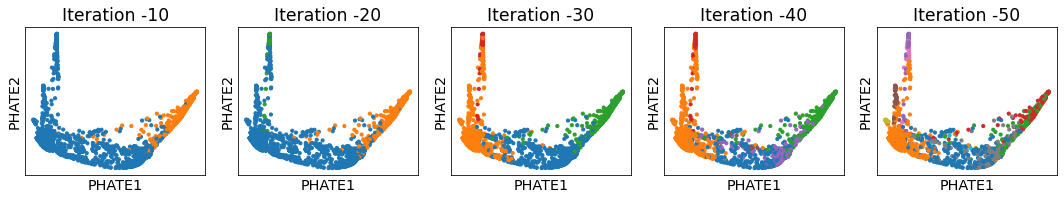

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,5, figsize=(15, 3))

for i, ax in enumerate(axes.flatten()):    

    scprep.plot.scatter2d(i_phate, c = NxTs[-8*(i+1)], legend=False,
                          legend_anchor=(1,1), ax=ax, title='Iteration '+str(-10*(i+1)),
                          xticks=False, yticks=False, label_prefix='PHATE', fontsize=10, s=10)
    #ax.axis('off')
fig.tight_layout()

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

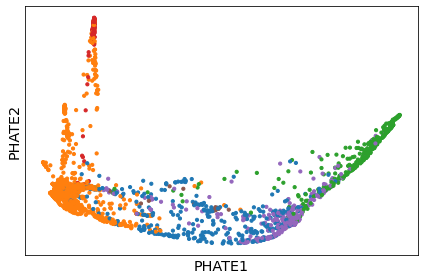

In [39]:
scprep.plot.scatter2d(i_phate, c = NxTs[-30], legend=False,
                          xticks=False, yticks=False, label_prefix='PHATE', fontsize=10, s=10)


<AxesSubplot:title={'center':'layer0'}>

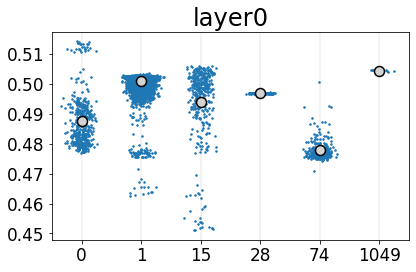

In [46]:
scprep.plot.jitter(NxTs[-30], integrated_meld_2, title='layer0')

In [47]:
integrated_meld_2_0a = integrated_meld_2[NxTs[-30] == 0]
integrated_meld_2_1a = integrated_meld_2[NxTs[-30] == 1]
integrated_meld_2_15a = integrated_meld_2[NxTs[-30] == 15]

In [48]:
i_diff_op_0a = pd.DataFrame(i_diff_op).iloc[NxTs[-30] == 0,NxTs[-30] == 0]
i_diff_op_1a = pd.DataFrame(i_diff_op).iloc[NxTs[-30] == 1,NxTs[-30] == 1]
i_diff_op_15a = pd.DataFrame(i_diff_op).iloc[NxTs[-30] == 15,NxTs[-30] == 15]

<AxesSubplot:title={'center':'layer1_cluster0'}>

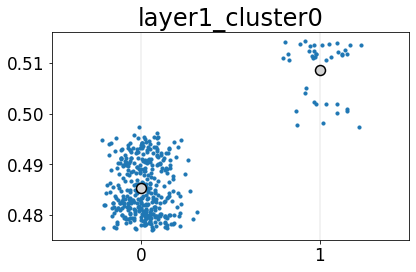

In [50]:
kmeans_0a = sklearn.cluster.KMeans(n_clusters=2, random_state=0).fit(np.log10(i_diff_op_0a))
scprep.plot.jitter(kmeans_0a.labels_, integrated_meld_2_0a, title='layer1_cluster0')

<AxesSubplot:title={'center':'layer1_cluster1'}>

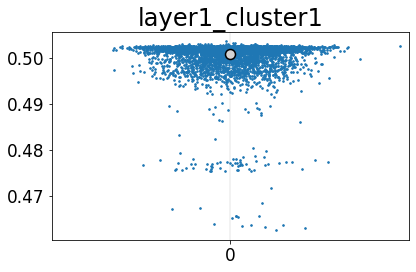

In [79]:
kmeans_1a = sklearn.cluster.KMeans(n_clusters=1, random_state=0).fit(np.log10(i_diff_op_1a))
scprep.plot.jitter(kmeans_1a.labels_, integrated_meld_2_1a, title='layer1_cluster1')

<AxesSubplot:title={'center':'layer1_cluster15'}>

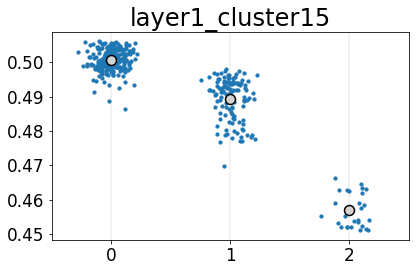

In [64]:
kmeans_15a = sklearn.cluster.KMeans(n_clusters=3, random_state=0).fit(np.log10(i_diff_op_15a))
scprep.plot.jitter(kmeans_15a.labels_, integrated_meld_2_15a, title='layer1_cluster15')

In [80]:
clusters = []
count0 = 0
count15 = 0

for val in NxTs[-30]:
    if val == 0:
        clusters.append('0_'+str(kmeans_0a.labels_[count0]))
        count0 += 1
    elif val == 1:
        clusters.append('1')
    elif val == 15:
        clusters.append('15_'+str(kmeans_15a.labels_[count15]))
        count15 += 1
    elif val == 28:
        clusters.append('28')
    elif val == 74:
        clusters.append('74')
    elif val == 1049:
        clusters.append('1049')


<AxesSubplot:title={'center':'layer0_final'}>

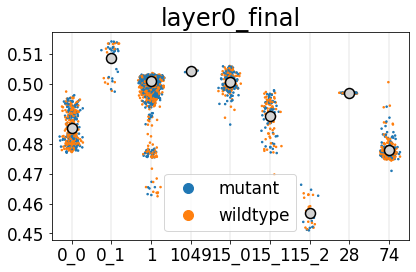

In [90]:
scprep.plot.jitter(clusters, integrated_meld_2, title='layer0_final', c=rna_adata.obs['sample'])

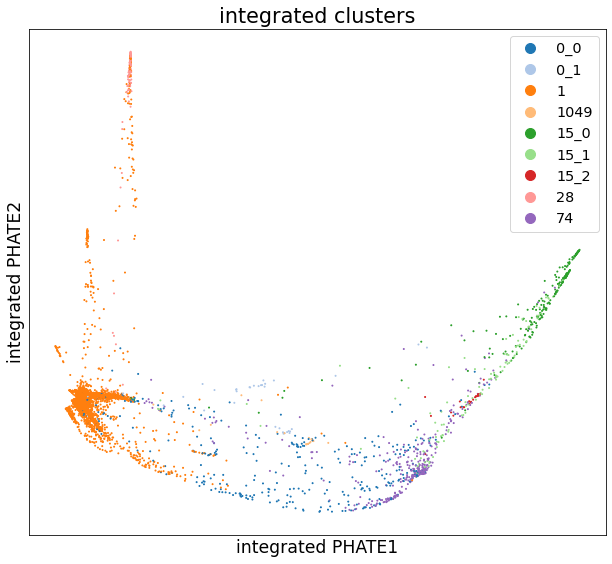

In [88]:
scprep.plot.scatter2d(i_phate, c=clusters, cmap='tab20', s=1,
                      figsize=(10,8), ticks=None, label_prefix='integrated PHATE',
                     legend_anchor=(1,1), fontsize=12, title='integrated clusters')

fig.tight_layout()